In [123]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

from pathlib import Path

from classifier.file_reader import read_files_from_folder
from evaluations.utils.wandb_loader import download_log_data, load_all_histories_to_dataframe
from plots.utils.plotting import write_figure_to_disk

NOTEBOOK_PATH = Path("experiments_llama3.ipynb").absolute().parent

DATA_DIR = f"{NOTEBOOK_PATH}/data/qwen2_online"

BENCHMARK_NAMES = ["arc_challenge", "arc_easy", "boolq", "lambada_standard", "logiqa", "logiqa2", "piqa", "sciq", "social_iqa", "winogrande", "non_iid_chained"]
MODEL_LABEL_NAMES = ["xsmall", "small", "medium", "large"]
MODEL_FAMILY = "qwen2"

# BENCHMARK_NAMES = ["winogrande"]

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica"
})



In [124]:
run_summary_df = download_log_data(
    entity="tum-i13",
    project_name="mess-plus_3-qwen2_online_vFINAL",
    save_dir=DATA_DIR,
    batch_size=50
)

2025-07-28 21:10:16,539 - evaluations.utils.wandb_loader - INFO - Loaded checkpoint: 189 runs already processed


True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


2025-07-28 21:10:19,674 - evaluations.utils.wandb_loader - INFO - Found 1701 total runs in project


True
True


True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


2025-07-28 21:12:00,870 - evaluations.utils.wandb_loader - INFO - Processing batch of 50 runs (starting at index 0)
2025-07-28 21:12:00,872 - evaluations.utils.wandb_loader - INFO - Processing batch of 50 runs (starting at index 50)
2025-07-28 21:12:00,873 - evaluations.utils.wandb_loader - INFO - Processing batch of 50 runs (starting at index 100)
2025-07-28 21:12:00,874 - evaluations.utils.wandb_loader - INFO - Processing batch of 50 runs (starting at index 150)
2025-07-28 21:12:00,876 - evaluations.utils.wandb_loader - INFO - Processing batch of 50 runs (starting at index 200)
2025-07-28 21:12:00,877 - evaluations.utils.wandb_loader - INFO - Processing batch of 50 runs (starting at index 250)
2025-07-28 21:12:00,879 - evaluations.utils.wandb_loader - INFO - Processing batch of 50 runs (starting at index 300)
2025-07-28 21:12:00,882 - evaluations.utils.wandb_loader - INFO - Processing batch of 50 runs (starting at index 350)
2025-07-28 21:12:00,884 - evaluations.utils.wandb_loader - 

True


In [125]:
display(run_summary_df)
run_df = load_all_histories_to_dataframe(DATA_DIR)

for name in BENCHMARK_NAMES:
	run_df.loc[run_df["run_name"].str.contains(name), "benchmark_name"] = name
	run_df.loc[run_df["run_name"].str.contains(name), "run_name"] = run_df.loc[run_df["run_name"].str.contains(name), "run_name"].str.replace(f"{name}_", "")

run_df[["V", "alpha", "c", "seed"]] = run_df["run_name"].str.split("_", expand=True)
run_df["alpha"] = run_df["alpha"].str.replace("a=", "")
run_df["V"] = run_df["V"].str.replace("V=", "")
run_df["c"] = run_df["c"].str.replace("c=", "")
run_df["seed"] = run_df["seed"].str.replace("seed=", "")
run_df["alpha"] = run_df["alpha"].astype(float)
run_df["V"] = run_df["V"].astype(float)
run_df["c"] = run_df["c"].astype(float)
run_df["seed"] = run_df["seed"].astype(int)

run_df["models/small_chosen"] = run_df["models/small_chosen"].astype(float)
run_df["models/medium_chosen"] = run_df["models/medium_chosen"].astype(float)
run_df["models/large_chosen"] = run_df["models/large_chosen"].astype(float)

display(run_df.head())

,id,name,path,url,created_at,tags,summary,config
0,dkqrhovt,non_iid_chained_V=1.0_a=0.59_c=1.0_seed=42,"[tum-i13, mess-plus_3-qwen2_online_vFINAL, dkq...",https://wandb.ai/tum-i13/mess-plus_3-qwen2_onl...,2025-07-28T05:05:28Z,[],"{'V': 1, 'alpha': 0.59, 'avg_accuracy': 0.5849...","{'seed': 43, 'lm_eval': {'benchmarks': ['non_i..."
1,41c2e6pq,non_iid_chained_V=0.1_a=0.59_c=1.0_seed=42,"[tum-i13, mess-plus_3-qwen2_online_vFINAL, 41c...",https://wandb.ai/tum-i13/mess-plus_3-qwen2_onl...,2025-07-28T05:10:10Z,[],"{'V': 0.1, 'alpha': 0.59, 'avg_accuracy': 0.59...","{'seed': 43, 'lm_eval': {'benchmarks': ['non_i..."
2,5fm8dwbs,non_iid_chained_V=0.01_a=0.59_c=1.0_seed=42,"[tum-i13, mess-plus_3-qwen2_online_vFINAL, 5fm...",https://wandb.ai/tum-i13/mess-plus_3-qwen2_onl...,2025-07-28T05:14:38Z,[],"{'V': 0.01, 'alpha': 0.59, 'avg_accuracy': 0.6...","{'seed': 43, 'lm_eval': {'benchmarks': ['non_i..."
3,e6qq7dh9,non_iid_chained_V=0.001_a=0.59_c=1.0_seed=42,"[tum-i13, mess-plus_3-qwen2_online_vFINAL, e6q...",https://wandb.ai/tum-i13/mess-plus_3-qwen2_onl...,2025-07-28T05:19:12Z,[],"{'V': 0.001, 'alpha': 0.59, 'avg_accuracy': 0....","{'seed': 43, 'lm_eval': {'benchmarks': ['non_i..."
4,k386745g,non_iid_chained_V=0.0001_a=0.59_c=1.0_seed=42,"[tum-i13, mess-plus_3-qwen2_online_vFINAL, k38...",https://wandb.ai/tum-i13/mess-plus_3-qwen2_onl...,2025-07-28T05:23:50Z,[],"{'V': 0.0001, 'alpha': 0.59, 'avg_accuracy': 0...","{'seed': 43, 'lm_eval': {'benchmarks': ['non_i..."
...,...,...,...,...,...,...,...,...
184,d678cgz1,non_iid_chained_V=0.01_a=0.67_c=0.01_seed=44,"[tum-i13, mess-plus_3-qwen2_online_vFINAL, d67...",https://wandb.ai/tum-i13/mess-plus_3-qwen2_onl...,2025-07-28T13:18:38Z,[],"{'V': 0.01, 'alpha': 0.67, 'avg_accuracy': 0.6...","{'seed': 43, 'lm_eval': {'benchmarks': ['non_i..."
185,qddebf38,non_iid_chained_V=0.001_a=0.67_c=0.01_seed=44,"[tum-i13, mess-plus_3-qwen2_online_vFINAL, qdd...",https://wandb.ai/tum-i13/mess-plus_3-qwen2_onl...,2025-07-28T13:20:09Z,[],"{'V': 0.001, 'alpha': 0.67, 'avg_accuracy': 0....","{'seed': 43, 'lm_eval': {'benchmarks': ['non_i..."
186,ij4artki,non_iid_chained_V=0.0001_a=0.67_c=0.01_seed=44,"[tum-i13, mess-plus_3-qwen2_online_vFINAL, ij4...",https://wandb.ai/tum-i13/mess-plus_3-qwen2_onl...,2025-07-28T13:21:38Z,[],"{'V': 0.0001, 'alpha': 0.67, 'avg_accuracy': 0...","{'seed': 43, 'lm_eval': {'benchmarks': ['non_i..."
187,9nut3ll6,non_iid_chained_V=1e-05_a=0.67_c=0.01_seed=44,"[tum-i13, mess-plus_3-qwen2_online_vFINAL, 9nu...",https://wandb.ai/tum-i13/mess-plus_3-qwen2_onl...,2025-07-28T13:23:07Z,[],"{'V': 1e-05, 'alpha': 0.67, 'avg_accuracy': 0....","{'seed': 43, 'lm_eval': {'benchmarks': ['non_i..."


2025-07-28 21:12:01,205 - evaluations.utils.wandb_loader - INFO - Found 1701 run directories


Loading run histories:   0%|          | 0/1701 [00:00<?, ?it/s]

2025-07-28 21:12:18,626 - evaluations.utils.wandb_loader - INFO - Combined DataFrame shape: (3734451, 30)
2025-07-28 21:12:18,627 - evaluations.utils.wandb_loader - INFO - Total rows: 3734451
2025-07-28 21:12:18,761 - evaluations.utils.wandb_loader - INFO - Unique runs: 1701
2025-07-28 21:12:18,762 - evaluations.utils.wandb_loader - INFO - Metrics available: ['mess_plus/energy', '_step', 'avg_accuracy', 'mess_plus/exploration_step_ratio', '_runtime', 'models/small_chosen', 'mess_plus/x_t', 'step_energy_consumption', 'models/medium_chosen', 'models/large_chosen', 'total_runtime', 'mess_plus/q_length', 'mess_plus/chosen_model', 'models/xsmall_chosen', 'mess_plus/p_t', 'step_time', '_timestamp', 'mess_plus/inference_only_energy', 'classifier/train_loss', 'mess_plus/total_energy_incl_classifier', 'classifier/train_step_energy', 'created_at']


,mess_plus/energy,_step,avg_accuracy,mess_plus/exploration_step_ratio,_runtime,models/small_chosen,mess_plus/x_t,step_energy_consumption,models/medium_chosen,models/large_chosen,...,config_lm_eval,config_run_name,config_algorithm,config_model_zoo,config_classifier_model,benchmark_name,V,alpha,c,seed
0,19.239,0,0.000000,0.0,0.701229,0.0,0,19.239,0.0,0.000000,...,NaN,baseline,NaN,NaN,NaN,boolq,0.00001,0.7,0.01,43
1,537.950,1,0.500000,0.0,0.741696,0.0,0,537.950,0.0,0.500000,...,NaN,baseline,NaN,NaN,NaN,boolq,0.00001,0.7,0.01,43
2,493.294,2,0.666667,0.0,0.741809,0.0,0,493.294,0.0,0.666667,...,NaN,baseline,NaN,NaN,NaN,boolq,0.00001,0.7,0.01,43
3,480.053,3,0.750000,0.0,0.759682,0.0,0,480.053,0.0,0.750000,...,NaN,baseline,NaN,NaN,NaN,boolq,0.00001,0.7,0.01,43
4,35.955,4,0.600000,0.0,0.779582,0.0,0,35.955,0.0,0.600000,...,NaN,baseline,NaN,NaN,NaN,boolq,0.00001,0.7,0.01,43


In [126]:
display(run_df.columns)
analysis_df = run_df.loc[(run_df["c"] == 1.0) & (run_df["benchmark_name"] == "winogrande")].pivot_table(index=["benchmark_name", "alpha", "V", "c"], values=["avg_accuracy", "mess_plus/total_energy_incl_classifier", "mess_plus/q_length", "total_runtime"], aggfunc={"avg_accuracy": "mean", "mess_plus/total_energy_incl_classifier": "sum", "mess_plus/q_length": "mean", "total_runtime": "max"})

Index(['mess_plus/energy', '_step', 'avg_accuracy',
       'mess_plus/exploration_step_ratio', '_runtime', 'models/small_chosen',
       'mess_plus/x_t', 'step_energy_consumption', 'models/medium_chosen',
       'models/large_chosen', 'total_runtime', 'mess_plus/q_length',
       'mess_plus/chosen_model', 'models/xsmall_chosen', 'mess_plus/p_t',
       'step_time', '_timestamp', 'mess_plus/inference_only_energy',
       'classifier/train_loss', 'mess_plus/total_energy_incl_classifier',
       'classifier/train_step_energy', 'run_id', 'run_name', 'created_at',
       'config_seed', 'config_lm_eval', 'config_run_name', 'config_algorithm',
       'config_model_zoo', 'config_classifier_model', 'benchmark_name', 'V',
       'alpha', 'c', 'seed'],
      dtype='object')

In [127]:
def add_value_labels(axx, spacing=5, convert_to_mj: bool = True):
    """Add labels to the end of each bar in a bar chart.

    Arguments:
        ax (matplotlib.axes.Axes): The matplotlib object containing the axes
            of the plot to annotate.
        spacing (int): The distance between the labels and the bars.
    """

    # For each bar: Place a label
    for rect in axx.patches:
        # Get X and Y placement of label from rect.
        y_value = rect.get_height()
        x_value = rect.get_x() + rect.get_width() / 2

        # Number of points between bar and label. Change to your liking.
        space = spacing
        # Vertical alignment for positive values
        va = 'bottom'

        # If value of bar is negative: Place label below bar
        if y_value < 0:
            # Invert space to place label below
            space *= -1
            # Vertically align label at top
            va = 'top'

        # Use Y value as label and format number with one decimal place
        if convert_to_mj:
            label = f'{y_value / 1_000_000:.1f}' # MJ conversion
        else:
            label = f'{y_value:.2f}'

        # Create annotation
        axx.annotate(
            label,                      # Use `label` as label
            (x_value, y_value),         # Place label at end of the bar
            xytext=(0, space),          # Vertically shift label by `space`
            textcoords="offset points", # Interpret `xytext` as offset in points
            ha='center',                # Horizontally center label
            va=va)                      # Vertically align label differently for
                                        # positive and negative values.

def fmt_to_megajoules(x, pos):
    return f'{(x / 1_000_000):.0f}'


In [155]:
# Load raw inference data

infer_df = pd.DataFrame()
def get_inference_data(benchmark_name):
	try:
		input_df = read_files_from_folder(folder_path=f"{NOTEBOOK_PATH.parent}/data/{MODEL_FAMILY}/inference_outputs/{benchmark_name}")
		input_df["idx_original"] = input_df.index
		input_df = input_df.sample(frac=1).reset_index(drop=True)

		return input_df
	except ValueError:
		return pd.DataFrame()

for name in BENCHMARK_NAMES:
	infer_df = pd.concat([infer_df, get_inference_data(name)], ignore_index=True)

infer_df.reset_index(inplace=True)

# Get baseline dataframe
BASELINE_DATA_DIR = f"{NOTEBOOK_PATH}/data/random_qwen2_baseline_v01"
baseline_summary_df = download_log_data(
    entity="tum-i13",
    project_name="mess_plus_qwen2_random_baseline_with_constraint_v01",
    save_dir=BASELINE_DATA_DIR,
    batch_size=5
)

baseline_df = load_all_histories_to_dataframe(BASELINE_DATA_DIR)

for benchmark in BENCHMARK_NAMES:
	baseline_df.loc[baseline_df["run_name"].str.contains(benchmark), "benchmark_name"] = benchmark
	baseline_df.loc[baseline_df["run_name"].str.contains(benchmark), "run_name"] = baseline_df.loc[baseline_df["run_name"].str.contains(benchmark), "run_name"].str.replace(f"{benchmark}_alpha=", "")
	baseline_df.loc[baseline_df["benchmark_name"] == benchmark, "alpha"] = baseline_df.loc[baseline_df["benchmark_name"] == benchmark, "run_name"]

	baseline_df["alpha"] = baseline_df["alpha"].astype(float)


print(baseline_df["benchmark_name"].unique())


2025-07-28 21:41:35,651 - evaluations.utils.wandb_loader - INFO - Loaded checkpoint: 3 runs already processed


True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


2025-07-28 21:41:37,190 - evaluations.utils.wandb_loader - INFO - Found 27 total runs in project


True
True


2025-07-28 21:41:37,194 - evaluations.utils.wandb_loader - INFO - Processing batch of 5 runs (starting at index 0)
2025-07-28 21:41:37,194 - evaluations.utils.wandb_loader - INFO - Processing batch of 5 runs (starting at index 5)
2025-07-28 21:41:37,195 - evaluations.utils.wandb_loader - INFO - Processing batch of 5 runs (starting at index 10)
2025-07-28 21:41:37,195 - evaluations.utils.wandb_loader - INFO - Processing batch of 5 runs (starting at index 15)
2025-07-28 21:41:37,195 - evaluations.utils.wandb_loader - INFO - Processing batch of 4 runs (starting at index 20)
2025-07-28 21:41:37,203 - evaluations.utils.wandb_loader - INFO - Download complete! Downloaded 3 runs
2025-07-28 21:41:37,203 - evaluations.utils.wandb_loader - INFO - All data saved to /Users/herbert/code/mess-plus/evaluations/data/random_qwen2_baseline_v01
2025-07-28 21:41:37,206 - evaluations.utils.wandb_loader - INFO - Found 27 run directories


Loading run histories:   0%|          | 0/27 [00:00<?, ?it/s]

2025-07-28 21:41:37,478 - evaluations.utils.wandb_loader - INFO - Combined DataFrame shape: (59277, 20)
2025-07-28 21:41:37,478 - evaluations.utils.wandb_loader - INFO - Total rows: 59277
2025-07-28 21:41:37,480 - evaluations.utils.wandb_loader - INFO - Unique runs: 27
2025-07-28 21:41:37,480 - evaluations.utils.wandb_loader - INFO - Metrics available: ['mess_plus/energy', '_step', 'model_choice', 'avg_accuracy', '_runtime', 'models/small_chosen', 'models/medium_chosen', 'models/large_chosen', 'mess_plus/q_length', 'models/xsmall_chosen', '_timestamp', 'created_at']
/var/folders/yz/mgc_jz0x28j0kgl9dm72cwp40000gn/T/ipykernel_62660/4003215388.py:33: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '['0.6' '0.6' '0.6' ... '0.7' '0.7' '0.7']' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  baseline_df.loc[baseline_df["benchmark_name"] == benchmark, "alpha"] = baseline_d

['piqa' 'sciq' 'social_iqa' 'winogrande' 'non_iid_chained' 'arc_easy'
 'boolq' 'logiqa' 'arc_challenge']


/var/folders/yz/mgc_jz0x28j0kgl9dm72cwp40000gn/T/ipykernel_62660/4003215388.py:33: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '['0.44' '0.44' '0.44' ... '0.47' '0.47' '0.47']' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  baseline_df.loc[baseline_df["benchmark_name"] == benchmark, "alpha"] = baseline_df.loc[baseline_df["benchmark_name"] == benchmark, "run_name"]
/var/folders/yz/mgc_jz0x28j0kgl9dm72cwp40000gn/T/ipykernel_62660/4003215388.py:33: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '['0.65' '0.65' '0.65' ... '0.6' '0.6' '0.6']' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  baseline_df.loc[baseline_df["benchmark_name"] == benchmark, "alpha"] = baseline_df.loc[baseline_df["benchmark_name"] == benchmark, "run_name"]
/var/folders/

In [129]:
# Load the RouteLLM evaluations
ROUTELLM_DATA_DIR = f"{NOTEBOOK_PATH}/data/routellm_baseline_v01"
routellm_summary_df = download_log_data(
    entity="tum-i13",
    project_name="routellm_baseline_v01",
    save_dir=ROUTELLM_DATA_DIR,
    batch_size=50
)

routellm_bs_df = load_all_histories_to_dataframe(ROUTELLM_DATA_DIR)

for benchmark in BENCHMARK_NAMES:
	routellm_bs_df.loc[routellm_bs_df["run_name"].str.contains(benchmark), "benchmark_name"] = benchmark
	routellm_bs_df.loc[routellm_bs_df["run_name"].str.contains(benchmark), "run_name_updated"] = routellm_bs_df.loc[routellm_bs_df["run_name"].str.contains(benchmark), "run_name"].str.replace(f"{benchmark}_", "")


routellm_bs_df[["alpha", "threshold"]] = routellm_bs_df["run_name_updated"].str.split("_", expand=True)
routellm_bs_df["alpha"] = routellm_bs_df["alpha"].str.replace("alpha=", "")
routellm_bs_df["threshold"] = routellm_bs_df["threshold"].str.replace("thres=", "")
routellm_bs_df["alpha"] = routellm_bs_df["alpha"].astype(float)
routellm_bs_df["threshold"] = routellm_bs_df["threshold"].astype(float)


2025-07-28 21:12:49,362 - evaluations.utils.wandb_loader - INFO - Loaded checkpoint: 27 runs already processed


True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


2025-07-28 21:12:52,180 - evaluations.utils.wandb_loader - INFO - Found 216 total runs in project


True
True


True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


2025-07-28 21:13:01,835 - evaluations.utils.wandb_loader - INFO - Processing batch of 50 runs (starting at index 0)
2025-07-28 21:13:01,836 - evaluations.utils.wandb_loader - INFO - Processing batch of 50 runs (starting at index 50)
2025-07-28 21:13:01,837 - evaluations.utils.wandb_loader - INFO - Processing batch of 50 runs (starting at index 100)
2025-07-28 21:13:01,838 - evaluations.utils.wandb_loader - INFO - Processing batch of 39 runs (starting at index 150)
2025-07-28 21:13:01,844 - evaluations.utils.wandb_loader - INFO - Download complete! Downloaded 27 runs
2025-07-28 21:13:01,845 - evaluations.utils.wandb_loader - INFO - All data saved to /Users/herbert/code/mess-plus/evaluations/data/routellm_baseline_v01
2025-07-28 21:13:01,849 - evaluations.utils.wandb_loader - INFO - Found 216 run directories


True
True
True


Loading run histories:   0%|          | 0/216 [00:00<?, ?it/s]

2025-07-28 21:13:03,428 - evaluations.utils.wandb_loader - INFO - Combined DataFrame shape: (355104, 20)
2025-07-28 21:13:03,428 - evaluations.utils.wandb_loader - INFO - Total rows: 355104
2025-07-28 21:13:03,438 - evaluations.utils.wandb_loader - INFO - Unique runs: 216
2025-07-28 21:13:03,438 - evaluations.utils.wandb_loader - INFO - Metrics available: ['mess_plus/energy', '_step', 'model_choice', 'avg_accuracy', '_runtime', 'routellm/router_energy', 'models/small_chosen', 'models/large_chosen', 'mess_plus/q_length', 'routellm/inference_energy', '_timestamp', 'created_at']


In [130]:
# Load the RouterDC evaluations
ROUTERDC_DATA_DIR = f"{NOTEBOOK_PATH}/data/routerdc_baseline_v01"
routellm_summary_df = download_log_data(
    entity="tum-i13",
    project_name="routerdc_baseline_v01",
    save_dir=ROUTERDC_DATA_DIR,
    batch_size=50
)

routerdc_bs_df = load_all_histories_to_dataframe(ROUTERDC_DATA_DIR)
routerdc_bs_df[["benchmark_name", "alpha"]] = routerdc_bs_df["run_name"].str.replace("routerdc-", "").str.split("-", expand=True)
routerdc_bs_df["alpha"] = routerdc_bs_df["alpha"].str.replace("alpha=", "").astype(float)

display(routerdc_bs_df)

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


2025-07-28 21:13:08,093 - evaluations.utils.wandb_loader - INFO - Found 24 total runs in project


True
True
True


2025-07-28 21:13:08,099 - evaluations.utils.wandb_loader - INFO - Processing batch of 24 runs (starting at index 0)
2025-07-28 21:13:08,104 - evaluations.utils.wandb_loader - INFO - Download complete! Downloaded 0 runs
2025-07-28 21:13:08,105 - evaluations.utils.wandb_loader - INFO - All data saved to /Users/herbert/code/mess-plus/evaluations/data/routerdc_baseline_v01
2025-07-28 21:13:08,108 - evaluations.utils.wandb_loader - INFO - Found 24 run directories


Loading run histories:   0%|          | 0/24 [00:00<?, ?it/s]

2025-07-28 21:13:08,282 - evaluations.utils.wandb_loader - INFO - Combined DataFrame shape: (39456, 21)
2025-07-28 21:13:08,282 - evaluations.utils.wandb_loader - INFO - Total rows: 39456
2025-07-28 21:13:08,284 - evaluations.utils.wandb_loader - INFO - Unique runs: 24
2025-07-28 21:13:08,284 - evaluations.utils.wandb_loader - INFO - Metrics available: ['mess_plus/energy', '_step', 'model_choice', 'avg_accuracy', '_runtime', 'routellm/router_energy', 'models/small_chosen', 'models/medium_chosen', 'models/large_chosen', 'mess_plus/q_length', 'routellm/inference_energy', '_timestamp', 'created_at']


,mess_plus/energy,_step,model_choice,avg_accuracy,_runtime,routellm/router_energy,models/small_chosen,models/medium_chosen,models/large_chosen,mess_plus/q_length,...,run_name,created_at,config_seed,config_lm_eval,config_run_name,config_algorithm,config_model_zoo,config_classifier_model,benchmark_name,alpha
0,1546.859000,0,2,0.000000,0.432314,24.318000,0.000000,0.000000,1.000000,0.44,...,social_iqa-alpha=0.44,2025-05-15T01:27:53Z,43,NaN,baseline,NaN,NaN,NaN,social_iqa,0.44
1,1552.898000,1,2,0.500000,0.432588,24.909000,0.000000,0.000000,1.000000,0.00,...,social_iqa-alpha=0.44,2025-05-15T01:27:53Z,43,NaN,baseline,NaN,NaN,NaN,social_iqa,0.44
2,1529.766131,2,2,0.333333,0.432956,2.370131,0.000000,0.000000,1.000000,0.44,...,social_iqa-alpha=0.44,2025-05-15T01:27:53Z,43,NaN,baseline,NaN,NaN,NaN,social_iqa,0.44
3,1553.678484,3,2,0.250000,0.433111,2.238484,0.000000,0.000000,1.000000,0.88,...,social_iqa-alpha=0.44,2025-05-15T01:27:53Z,43,NaN,baseline,NaN,NaN,NaN,social_iqa,0.44
4,1551.736000,4,2,0.200000,0.433354,15.203000,0.000000,0.000000,1.000000,1.32,...,social_iqa-alpha=0.44,2025-05-15T01:27:53Z,43,NaN,baseline,NaN,NaN,NaN,social_iqa,0.44
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39451,1056.269323,3265,2,0.873852,1.345906,2.673323,0.001531,0.425903,0.572566,0.00,...,boolq-alpha=0.7,2025-05-15T01:28:05Z,43,NaN,baseline,NaN,NaN,NaN,boolq,0.70
39452,1055.835262,3266,2,0.873890,1.346197,2.487262,0.001530,0.425773,0.572697,0.00,...,boolq-alpha=0.7,2025-05-15T01:28:05Z,43,NaN,baseline,NaN,NaN,NaN,boolq,0.70
39453,132.355951,3267,1,0.873929,1.346491,2.493951,0.001530,0.425949,0.572521,0.00,...,boolq-alpha=0.7,2025-05-15T01:28:05Z,43,NaN,baseline,NaN,NaN,NaN,boolq,0.70
39454,136.287998,3268,1,0.873968,1.346754,2.781998,0.001530,0.426124,0.572346,0.00,...,boolq-alpha=0.7,2025-05-15T01:28:05Z,43,NaN,baseline,NaN,NaN,NaN,boolq,0.70


In [131]:
ROUTELLM_THRESHOLD_ALPHA_MAP = {}
for benchmark in BENCHMARK_NAMES:
	routellm_subset = routellm_bs_df.loc[(routellm_bs_df["benchmark_name"] == benchmark)]

	if len(routellm_subset) == 0:
		continue

	# sns.set_style("whitegrid")
	# sns.set_theme(context='paper', style='whitegrid', palette='colorblind', font='sans-serif', font_scale=1.8, color_codes=True, rc=None)
	#
	# # Create a figure and a grid of subplots: 4 rows, 10 columns
	# fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 5))

	alpha_vals_bm = routellm_subset["alpha"].unique().tolist()
	threshold_vals = routellm_subset["threshold"].sort_values(ascending=False).unique().tolist()

	thres_acc_mapping = {i: 0.0 for i in threshold_vals}
	alpha_thresh_mapping = {a: 0.0 for a in alpha_vals_bm}
	# Get final accuracy for each threshold
	for alpha in alpha_vals_bm:
		alpha_thres_value_match = False
		for thresh in threshold_vals:

			if alpha_thres_value_match is True:
				continue

			data = routellm_subset.loc[(routellm_subset["alpha"] == alpha) & (routellm_subset["threshold"] == thresh)]
			threshold_accuracy = data.loc[data["_step"] > data["_step"].max() - 30, ["avg_accuracy"]].mean()

			if threshold_accuracy.item() >= alpha:
				alpha_thresh_mapping[alpha] = thresh
				alpha_thres_value_match = True

	ROUTELLM_THRESHOLD_ALPHA_MAP[benchmark] = alpha_thresh_mapping

display(ROUTELLM_THRESHOLD_ALPHA_MAP)


{'arc_challenge': {0.5: 0.7, 0.6: 0.6, 0.4: 0.7},
 'arc_easy': {0.8: 0.6, 0.65: 0.7, 0.75: 0.6},
 'boolq': {0.8: 0.5, 0.85: 0.5, 0.7: 0.6},
 'logiqa': {0.3: 0.7, 0.45: 0.5, 0.4: 0.5},
 'piqa': {0.75: 0.6, 0.81: 0.5, 0.78: 0.6},
 'sciq': {0.97: 0.5, 0.95: 0.6, 0.96: 0.5},
 'social_iqa': {0.44: 0.7, 0.46: 0.7, 0.42: 0.7},
 'winogrande': {0.75: 0.5, 0.65: 0.6, 0.7: 0.5}}

In [132]:
v_values_per_benchmark = {
    "arc_challenge": [0.001, 0.0001, 0.00001],
    "arc_easy": [0.01, 0.001, 0.0001],
    "boolq": [0.01, 0.001, 0.0001],
    # "lambada_standard": [0.01, 0.001, 0.0001],
    "logiqa": [0.001, 0.0001, 0.00001],
    # "logiqa2": [0.01, 0.001, 0.0001],
    "piqa": [0.01, 0.001, 0.0001],
    "sciq": [0.0001, 0.00001, 0.000001],
    "social_iqa": [0.001, 0.0001, 0.00001],
    "winogrande": [0.01, 0.001, 0.0001],
    "non_iid_chained": [0.001, 0.0001, 0.00001],
}

/var/folders/yz/mgc_jz0x28j0kgl9dm72cwp40000gn/T/ipykernel_62660/1694984426.py:40: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  sns.lineplot(
/var/folders/yz/mgc_jz0x28j0kgl9dm72cwp40000gn/T/ipykernel_62660/1694984426.py:40: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  sns.lineplot(
/var/folders/yz/mgc_jz0x28j0kgl9dm72cwp40000gn/T/ipykernel_62660/1694984426.py:40: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  sns.lineplot(


Plot saved.


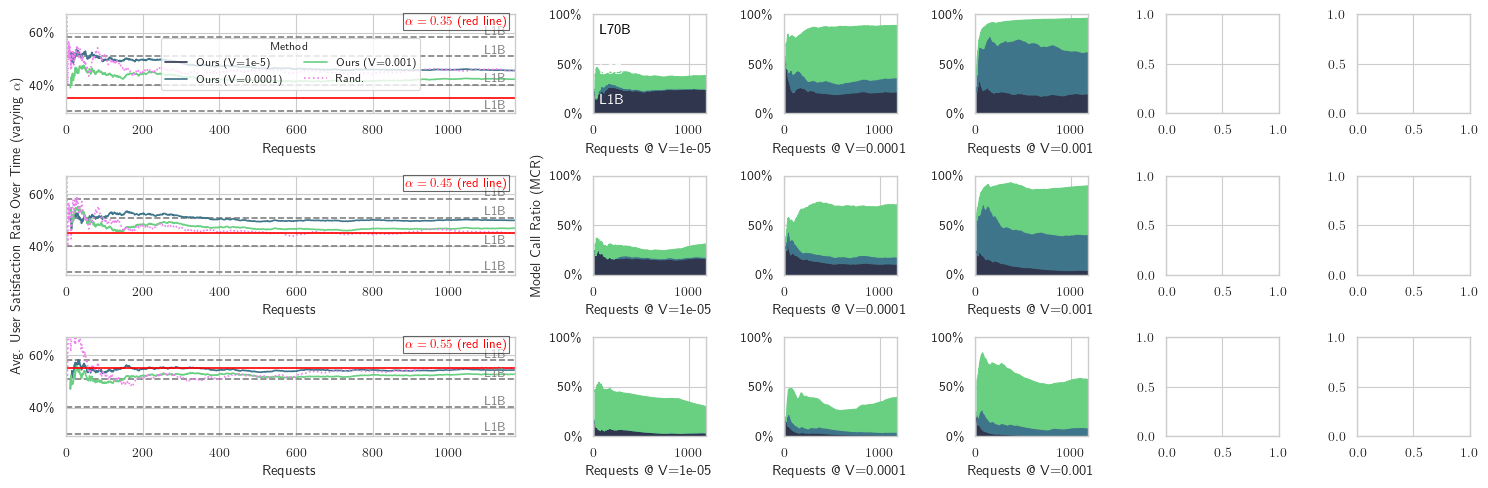

In [133]:
# Set the style for all plots
sns.set_style("whitegrid")
sns.set_palette(palette="dark:#5A9_r")

sns.set_theme(context='paper', style='whitegrid', palette='dark:#5A9_r', font='sans-serif', font_scale=1.1, color_codes=True, rc=None)

# Create a figure and a grid of subplots: 4 rows, 10 columns
fig, axes = plt.subplots(nrows=3, ncols=6, figsize=(15, 5), gridspec_kw={'width_ratios': [4, 1, 1, 1, 1, 1]})

# # Flatten the 2D array of axes for easier iteration
# axes = axes.flatten()

name = "arc_challenge"
subset = run_df.loc[(run_df["benchmark_name"] == name) & (run_df["c"] == 0.1) & (run_df["V"].isin(v_values_per_benchmark[name])) & (run_df["_step"] > 10)]
subset = subset.sort_values(by=["alpha"])

def format_v_value(b):
	if b < 0.0001:
		b = b * 100
		b = b / 100

	return f"Ours (V={b})"

subset["V"] = subset["V"].apply(format_v_value)

iterator = 0
for alpha in subset["alpha"].unique().tolist():
	v_values = subset["V"].unique().tolist()
	c_values = subset["c"].unique().tolist()

	# alpha = target_alpha_per_benchmark[name]

	# Accuracy Plot
	raw_inference_accuracies_per_model = infer_df[["benchmark_name"]+[f"label_{name}" for name in MODEL_LABEL_NAMES]].groupby("benchmark_name").mean().loc[name]

	for model in MODEL_LABEL_NAMES:
		axes[iterator][0].text(s="L1B", x=subset["_step"].max() - 20, y=raw_inference_accuracies_per_model[f"label_{model}"] + 0.01, color='gray', fontsize=9, ha="right")
		axes[iterator][0].axhline(y=raw_inference_accuracies_per_model[f"label_{model}"], color='gray', linestyle='--')

	sns.lineplot(
	    data=subset.loc[(subset["alpha"] == alpha)],
	    x="_step",
	    y="avg_accuracy",
	    hue="V",
		errorbar=None,
		ax=axes[iterator][0],
		legend=True if iterator == 0 else False,
		palette=["#2f364d", "#3f758a", "#69cf81", "#7c7c7c"][:len(MODEL_LABEL_NAMES)],
		hue_order=["Ours (V=1e-5)", "Ours (V=0.0001)", "Ours (V=0.001)"],
	)

	axes[iterator][0].plot(
		baseline_df.loc[(baseline_df["benchmark_name"] == name) & (baseline_df["alpha"] == alpha), "_step"],
		baseline_df.loc[(baseline_df["benchmark_name"] == name) & (baseline_df["alpha"] == alpha),"avg_accuracy"],
		color="violet", linestyle="dotted", label="Rand."
	)

	# Add RouteLLM baseline
	# axes[iterator][0].plot(
	# 	routellm_bs_df.loc[(routellm_bs_df["benchmark_name"] == name) & (routellm_bs_df["alpha"] == alpha) & (routellm_bs_df["threshold"] == ROUTELLM_THRESHOLD_ALPHA_MAP[name][alpha]), "_step"],
	# 	routellm_bs_df.loc[(routellm_bs_df["benchmark_name"] == name) & (routellm_bs_df["alpha"] == alpha) & (routellm_bs_df["threshold"] == ROUTELLM_THRESHOLD_ALPHA_MAP[name][alpha]), "avg_accuracy"],
	# 	color="brown", linestyle="dotted", label="RouteLLM"
	# )

	if iterator == 0:
		axes[iterator][0].legend(loc="center", ncol=2, title="Method", fontsize=8, title_fontsize=8)

	axes[iterator][0].axhline(y=alpha, color='red', linestyle='-', label="alpha")
	axes[iterator][0].set(ylim=[0.97 * raw_inference_accuracies_per_model[f"label_{MODEL_LABEL_NAMES[0]}"], 1.15 * raw_inference_accuracies_per_model[f"label_{MODEL_LABEL_NAMES[-1]}"]])
	axes[iterator][0].yaxis.set_major_formatter(mtick.PercentFormatter(1.0, decimals=0))

	# Add alpha marker
	t1 = axes[iterator][0].text(s=r"$ \alpha = {alpha_val} $ (red line)".format(alpha_val=alpha), x=subset["_step"].max() - 20, y=1.15 * raw_inference_accuracies_per_model[f"label_{MODEL_LABEL_NAMES[-1]}"] - 0.04, color='red', fontsize=9, ha="right")
	t1.set_bbox(dict(facecolor='white', alpha=0.6, edgecolor='black', pad=1.5))

	# Stackplot for Model Call Ratio
	v_values_per_benchmark[name] = sorted(v_values_per_benchmark[name], reverse=False)
	# v_values_per_benchmark[name].reverse()
	for jdx, V in enumerate(v_values_per_benchmark[name]):

		stack_df = subset.loc[
			(run_df["benchmark_name"] == name) &
			(run_df["V"] == V) &
			(subset["alpha"] == alpha),
			["_step"] + [f"models/{name}_chosen" for name in MODEL_LABEL_NAMES]
		].groupby(["_step"]).mean().reset_index()

		x = stack_df["_step"]
		y = stack_df[[f"models/{name}_chosen" for name in MODEL_LABEL_NAMES]]
		y_stack = np.cumsum(y, axis=1)

		axes[iterator][1 + jdx].fill_between(x, 0, y_stack.iloc[:, 0], color="#2f364d", alpha=1.0)
		axes[iterator][1 + jdx].fill_between(x, y_stack.iloc[:, 0], y_stack.iloc[:, 1], color="#3f758a", alpha=1.0)
		axes[iterator][1 + jdx].fill_between(x, y_stack.iloc[:, 1], y_stack.iloc[:, 2], color="#69cf81", alpha=1.0)
		axes[iterator][1 + jdx].set(xlabel=f"Requests @ V={V}", xlim=[0, subset.loc[(subset["alpha"] == alpha), "_step"].max()], ylim=[0, 1])
		axes[iterator][1 + jdx].yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
		axes[iterator][1 + jdx].set(xlim=[0, stack_df["_step"].max()])

		if iterator == 0 and jdx == 0:
			axes[iterator][1 + jdx].text(s="L70B", x=70, y=0.80, color="black")
			axes[iterator][1 + jdx].text(s="L8B", x=70, y=0.40, color="white")
			axes[iterator][1 + jdx].text(s="L1B", x=70, y=0.10, color="white")

	# Add area plot for random baseline with constraint.
	# baseline_stack_df = baseline_df.loc[
	# 		(baseline_df["benchmark_name"] == name) &
	# 		(baseline_df["alpha"] == alpha),
	# 		["_step"] + [f"models/{name}_chosen" for name in MODEL_LABEL_NAMES]
	# 	].groupby(["_step"]).mean().reset_index()
	#
	# x_base = baseline_stack_df["_step"]
	# y_base = baseline_stack_df[[f"models/{name}_chosen" for name in MODEL_LABEL_NAMES]]
	# y_stack_base = np.cumsum(y_base, axis=1)
	#
	# axes[iterator][4].fill_between(x_base, 0, y_stack_base.iloc[:, 0], color="#2f364d", alpha=0.95)
	# axes[iterator][4].fill_between(x_base, y_stack_base.iloc[:, 0], y_stack_base.iloc[:, 1], color="#3f758a", alpha=0.95)
	# axes[iterator][4].fill_between(x_base, y_stack_base.iloc[:, 1], y_stack_base.iloc[:, 2], color="#69cf81", alpha=0.95)
	# axes[iterator][4].set(xlabel=f"Requests (Rand.)", xlim=[0, baseline_stack_df["_step"].max()], ylim=[0, 1])
	# axes[iterator][4].yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
	# axes[iterator][4].set(xlim=[0, baseline_stack_df["_step"].max()])
	## axes[iterator][6].get_yaxis().set_visible(False)

	# Add area plot for RouteLLM baseline
	# routellm_stack_df = routellm_bs_df.loc[
	# 		(routellm_bs_df["benchmark_name"] == name) &
	# 		(routellm_bs_df["alpha"] == alpha) & (routellm_bs_df["threshold"] == ROUTELLM_THRESHOLD_ALPHA_MAP[name][alpha]),
	# 		["_step", "models/small_chosen", "models/large_chosen"]
	# 	].groupby(["_step"]).mean().reset_index()

	# x_rllm = routellm_stack_df["_step"]
	# y_rllm = routellm_stack_df[["models/small_chosen", "models/large_chosen"]]
	# y_stack_rllm = np.cumsum(y_rllm, axis=1)

	# axes[iterator][5].fill_between(x_rllm, 0, y_stack_rllm.iloc[:, 0], color="#2f364d", alpha=0.95)
	# axes[iterator][5].fill_between(x_rllm, y_stack_rllm.iloc[:, 0], y_stack_rllm.iloc[:, 1], color="#69cf81", alpha=0.95)
	# axes[iterator][6].fill_between(x_rllm, y_stack_rllm.iloc[:, 1], y_stack_rllm.iloc[:, 2], color="#69cf81", alpha=0.95)
	# axes[iterator][5].set(xlabel=f"Req. (RouteLLM)", xlim=[0, routellm_stack_df["_step"].max()], ylim=[0, 1])
	# axes[iterator][5].yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
	# axes[iterator][5].set(xlim=[0, routellm_stack_df["_step"].max()])

	axes[iterator][0].set(xlabel="Requests", xlim=[0, subset.loc[(subset["alpha"] == alpha), "_step"].max()])
	axes[iterator][0].set(ylabel=None)

	for ax, col in zip(axes[iterator], [r"Avg. User Satisfaction Rate Over Time (varying $\alpha$)".format(alpha_val=alpha), "Model Call Ratio (MCR)", "", ""]):

		if iterator == 1:
			ax.set_ylabel(col, rotation=90, size=10)

	iterator += 1

fig.tight_layout()
write_figure_to_disk(plt, file_name=f"{name}_{MODEL_FAMILY}_all_alpha", chapter_name="evaluations")


Plot saved.


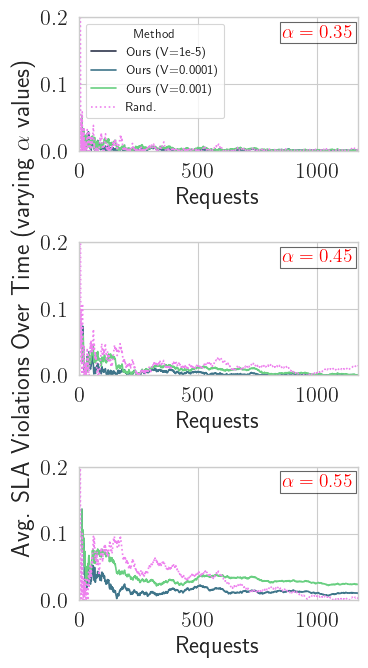

In [134]:
# Set the style for all plots
sns.set_style("whitegrid")
sns.set_palette(palette="dark:#5A9_r")

sns.set_theme(context='paper', style='whitegrid', palette='dark:#5A9_r', font='sans-serif', font_scale=1.8, color_codes=True, rc=None)

# Create a figure and a grid of subplots: 4 rows, 10 columns
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(4, 7))

# # Flatten the 2D array of axes for easier iteration
# axes = axes.flatten()

name = "arc_challenge"
subset = run_df.loc[(run_df["benchmark_name"] == name) & (run_df["c"] == 0.1) & (run_df["V"].isin(v_values_per_benchmark[name])) & (run_df["_step"] > 10)]
subset = subset.sort_values(by=["alpha"])

def format_v_value(b):
	if b < 0.0001:
		b = b * 100
		b = b / 100

	return f"Ours (V={b})"

subset["V"] = subset["V"].apply(format_v_value)

iterator = 0
for alpha in subset["alpha"].unique().tolist():
	v_values = subset["V"].unique().tolist()
	c_values = subset["c"].unique().tolist()

	# Q Plot for SLA violations
	subset.loc[(subset["alpha"] == alpha), "sla_violations"] = subset.loc[(subset["alpha"] == alpha), "mess_plus/q_length"] / subset.loc[(subset["alpha"] == alpha), "_step"]

	baseline_df.loc[(baseline_df["alpha"] == alpha), "sla_violations"] = baseline_df.loc[(baseline_df["alpha"] == alpha), "mess_plus/q_length"] / baseline_df.loc[(baseline_df["alpha"] == alpha), "_step"]

	# routellm_bs_df.loc[(routellm_bs_df["benchmark_name"] == name) & (routellm_bs_df["alpha"] == alpha) & (routellm_bs_df["threshold"] == ROUTELLM_THRESHOLD_ALPHA_MAP[name][alpha]), "sla_violations"] = routellm_bs_df.loc[(routellm_bs_df["benchmark_name"] == name) & (routellm_bs_df["alpha"] == alpha) & (routellm_bs_df["threshold"] == ROUTELLM_THRESHOLD_ALPHA_MAP[name][alpha]), "mess_plus/q_length"] / routellm_bs_df.loc[(routellm_bs_df["benchmark_name"] == name) & (routellm_bs_df["alpha"] == alpha) & (routellm_bs_df["threshold"] == ROUTELLM_THRESHOLD_ALPHA_MAP[name][alpha]), "_step"]

	sns.lineplot(
	    data=subset.loc[(subset["alpha"] == alpha)],
	    x="_step",
	    y="sla_violations",
	    hue="V",
		errorbar=None,
		ax=axes[iterator],
		legend=True if iterator == 0 else False,
		palette=["#2f364d", "#3f758a", "#69cf81"],
		hue_order=["Ours (V=1e-5)", "Ours (V=0.0001)", "Ours (V=0.001)"],
	)

	axes[iterator].plot(
		baseline_df.loc[(baseline_df["benchmark_name"] == name) & (baseline_df["alpha"] == alpha), "_step"],
		baseline_df.loc[(baseline_df["benchmark_name"] == name) & (baseline_df["alpha"] == alpha),"sla_violations"],
		color="violet", linestyle="dotted", label="Rand."
	)

	# Add RouteLLM baseline
	# axes[iterator].plot(
	# 	routellm_bs_df.loc[(routellm_bs_df["benchmark_name"] == name) & (routellm_bs_df["alpha"] == alpha) & (routellm_bs_df["threshold"] == ROUTELLM_THRESHOLD_ALPHA_MAP[name][alpha]), "_step"],
	# 	routellm_bs_df.loc[(routellm_bs_df["benchmark_name"] == name) & (routellm_bs_df["alpha"] == alpha) & (routellm_bs_df["threshold"] == ROUTELLM_THRESHOLD_ALPHA_MAP[name][alpha]), "sla_violations"],
	# 	color="brown", linestyle="dotted", label="RouteLLM"
	# )

	axes[iterator].set_ylim([0, 0.2])

	# Add alpha marker
	t1 = axes[iterator].text(s=r"$ \alpha = {alpha_val} $".format(alpha_val=alpha), x=subset["_step"].max() - 20, y=0.17, color='red', fontsize=14, ha="right")
	t1.set_bbox(dict(facecolor='white', alpha=0.6, edgecolor='black', pad=1.5))

	if iterator == 0:
		axes[iterator].legend(ncols=1, title="Method", fontsize=9, title_fontsize=9, loc='upper left')

	axes[iterator].set(xlabel="Requests", xlim=[0, subset.loc[(subset["alpha"] == alpha), "_step"].max()])

	axes[iterator].set(ylabel=None)

	for ax, col in zip(axes, ["", r"Avg. SLA Violations Over Time (varying $\alpha$ values)", ""]):
		ax.set_ylabel(col, rotation=90, size=18)

	iterator += 1

fig.tight_layout()
write_figure_to_disk(plt, file_name=f"{name}_sla_violations", chapter_name="evaluations")

In [135]:
print(infer_df.columns)
print(infer_df.groupby("benchmark_name")["energy_consumption_large"].mean())
print(infer_df.groupby("benchmark_name")["energy_consumption_medium"].mean())
print(infer_df.groupby("benchmark_name")["energy_consumption_small"].mean())

Index(['index', 'input_text', 'benchmark_name', 'label_xsmall',
       'acc_norm_xsmall', 'energy_consumption_xsmall', 'inference_time_xsmall',
       'label_small', 'acc_norm_small', 'energy_consumption_small',
       'inference_time_small', 'label_medium', 'acc_norm_medium',
       'energy_consumption_medium', 'inference_time_medium', 'label_large',
       'acc_norm_large', 'energy_consumption_large', 'inference_time_large',
       'idx_original', 'acc_xsmall', 'acc_small', 'acc_medium', 'acc_large'],
      dtype='object')
benchmark_name
arc_challenge    1137.563677
arc_easy         1149.512261
boolq             498.863984
logiqa           1234.879246
piqa              574.578393
sciq             1192.103547
social_iqa        855.129011
winogrande        575.617376
Name: energy_consumption_large, dtype: float64
benchmark_name
arc_challenge    262.017343
arc_easy         294.817604
boolq             76.570473
logiqa            98.265720
piqa             136.220394
sciq             336

In [144]:
# If there is a non-stationary benchmark named "non_iid_chained", we need to compute the scores for it


non_stat_bm = infer_df.loc[infer_df["benchmark_name"].isin(["arc_challenge", "piqa", "winogrande"])].copy(deep=True)
non_stat_bm["benchmark_name"] = "non_iid_chained"
display(non_stat_bm["benchmark_name"].unique())

infer_df = pd.concat([infer_df, non_stat_bm], ignore_index=True)


array(['non_iid_chained'], dtype=object)

/var/folders/yz/mgc_jz0x28j0kgl9dm72cwp40000gn/T/ipykernel_62660/1493979852.py:68: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  sns.lineplot(
/var/folders/yz/mgc_jz0x28j0kgl9dm72cwp40000gn/T/ipykernel_62660/1493979852.py:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset.loc[(subset["alpha"] == alpha), "sla_violations"] = subset.loc[(subset["alpha"] == alpha), "mess_plus/q_length"] / subset.loc[(subset["alpha"] == alpha), "_step"]
/var/folders/yz/mgc_jz0x28j0kgl9dm72cwp40000gn/T/ipykernel_62660/1493979852.py:68: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  sns.lineplot(
/var/folders/yz/mgc_jz0x28j0kgl9dm72cwp40000gn/T/ipykernel_62660/149397

Plot saved.


/var/folders/yz/mgc_jz0x28j0kgl9dm72cwp40000gn/T/ipykernel_62660/1493979852.py:68: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  sns.lineplot(
/var/folders/yz/mgc_jz0x28j0kgl9dm72cwp40000gn/T/ipykernel_62660/1493979852.py:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset.loc[(subset["alpha"] == alpha), "sla_violations"] = subset.loc[(subset["alpha"] == alpha), "mess_plus/q_length"] / subset.loc[(subset["alpha"] == alpha), "_step"]
/var/folders/yz/mgc_jz0x28j0kgl9dm72cwp40000gn/T/ipykernel_62660/1493979852.py:68: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  sns.lineplot(
/var/folders/yz/mgc_jz0x28j0kgl9dm72cwp40000gn/T/ipykernel_62660/149397

Plot saved.


/var/folders/yz/mgc_jz0x28j0kgl9dm72cwp40000gn/T/ipykernel_62660/1493979852.py:68: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  sns.lineplot(
/var/folders/yz/mgc_jz0x28j0kgl9dm72cwp40000gn/T/ipykernel_62660/1493979852.py:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset.loc[(subset["alpha"] == alpha), "sla_violations"] = subset.loc[(subset["alpha"] == alpha), "mess_plus/q_length"] / subset.loc[(subset["alpha"] == alpha), "_step"]
/var/folders/yz/mgc_jz0x28j0kgl9dm72cwp40000gn/T/ipykernel_62660/1493979852.py:68: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  sns.lineplot(
/var/folders/yz/mgc_jz0x28j0kgl9dm72cwp40000gn/T/ipykernel_62660/149397

Plot saved.


/var/folders/yz/mgc_jz0x28j0kgl9dm72cwp40000gn/T/ipykernel_62660/1493979852.py:68: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  sns.lineplot(
/var/folders/yz/mgc_jz0x28j0kgl9dm72cwp40000gn/T/ipykernel_62660/1493979852.py:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset.loc[(subset["alpha"] == alpha), "sla_violations"] = subset.loc[(subset["alpha"] == alpha), "mess_plus/q_length"] / subset.loc[(subset["alpha"] == alpha), "_step"]
/var/folders/yz/mgc_jz0x28j0kgl9dm72cwp40000gn/T/ipykernel_62660/1493979852.py:68: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  sns.lineplot(
/var/folders/yz/mgc_jz0x28j0kgl9dm72cwp40000gn/T/ipykernel_62660/149397

Plot saved.


/var/folders/yz/mgc_jz0x28j0kgl9dm72cwp40000gn/T/ipykernel_62660/1493979852.py:68: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  sns.lineplot(
/var/folders/yz/mgc_jz0x28j0kgl9dm72cwp40000gn/T/ipykernel_62660/1493979852.py:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset.loc[(subset["alpha"] == alpha), "sla_violations"] = subset.loc[(subset["alpha"] == alpha), "mess_plus/q_length"] / subset.loc[(subset["alpha"] == alpha), "_step"]
/var/folders/yz/mgc_jz0x28j0kgl9dm72cwp40000gn/T/ipykernel_62660/1493979852.py:68: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  sns.lineplot(
/var/folders/yz/mgc_jz0x28j0kgl9dm72cwp40000gn/T/ipykernel_62660/149397

Plot saved.


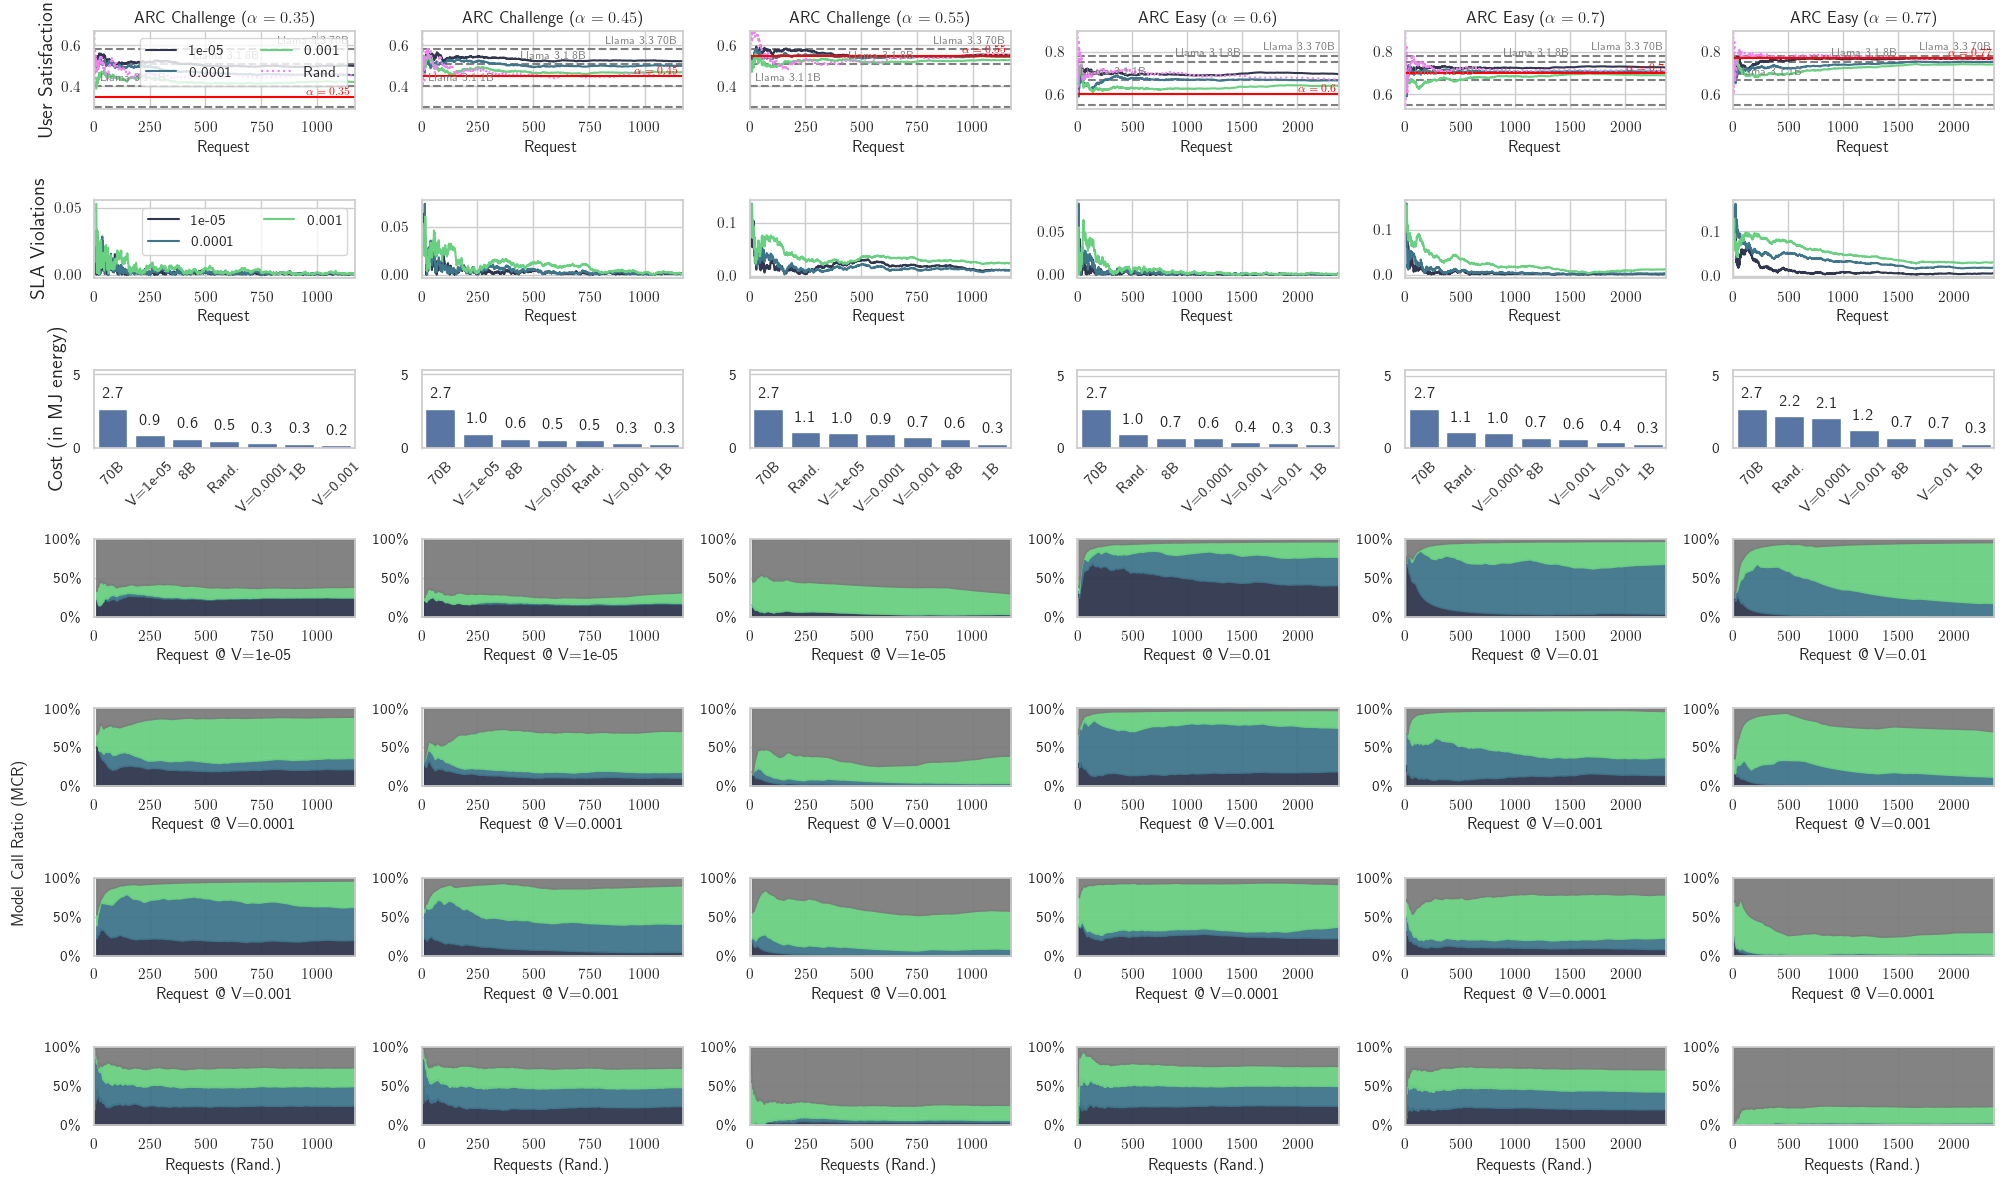

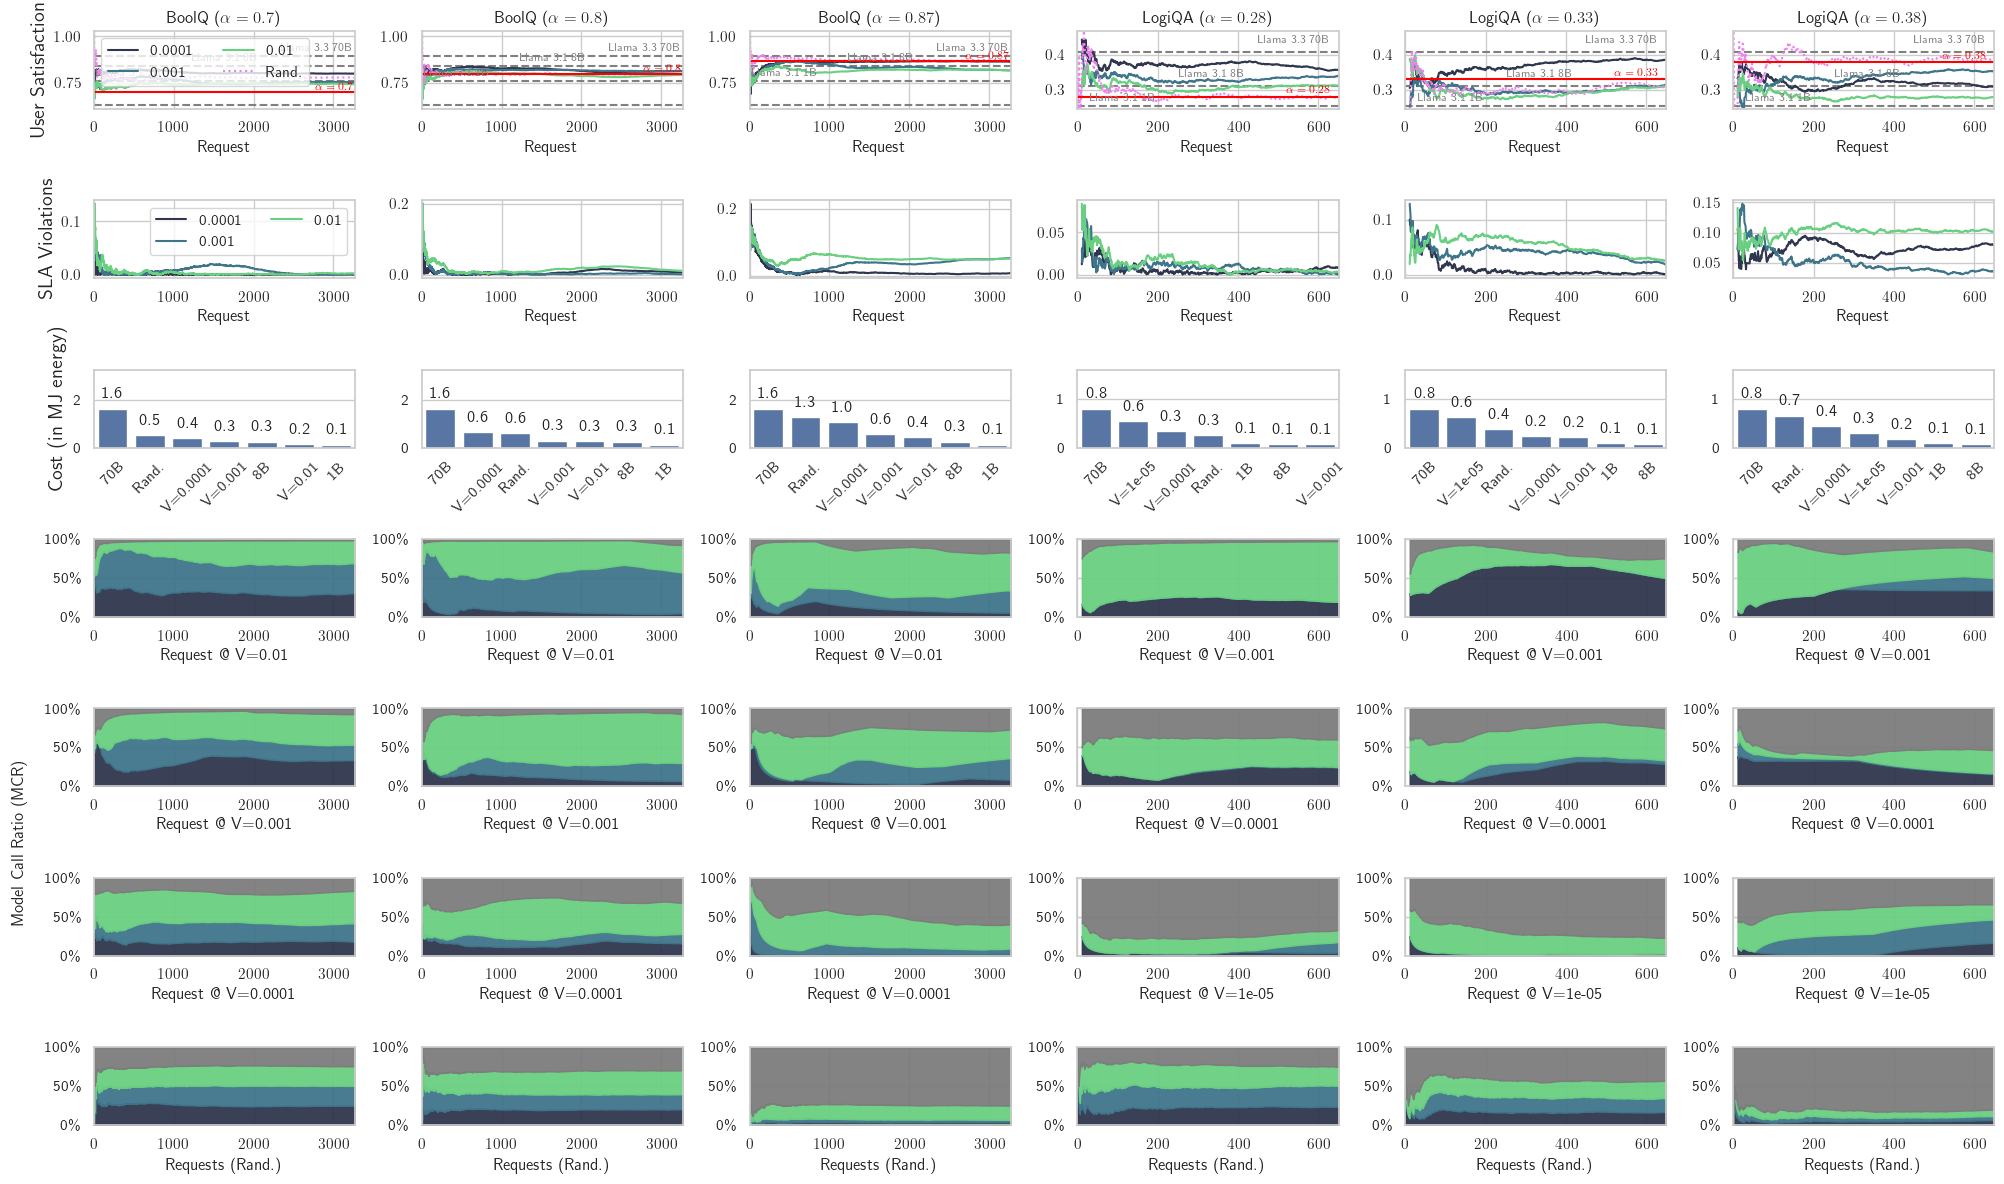

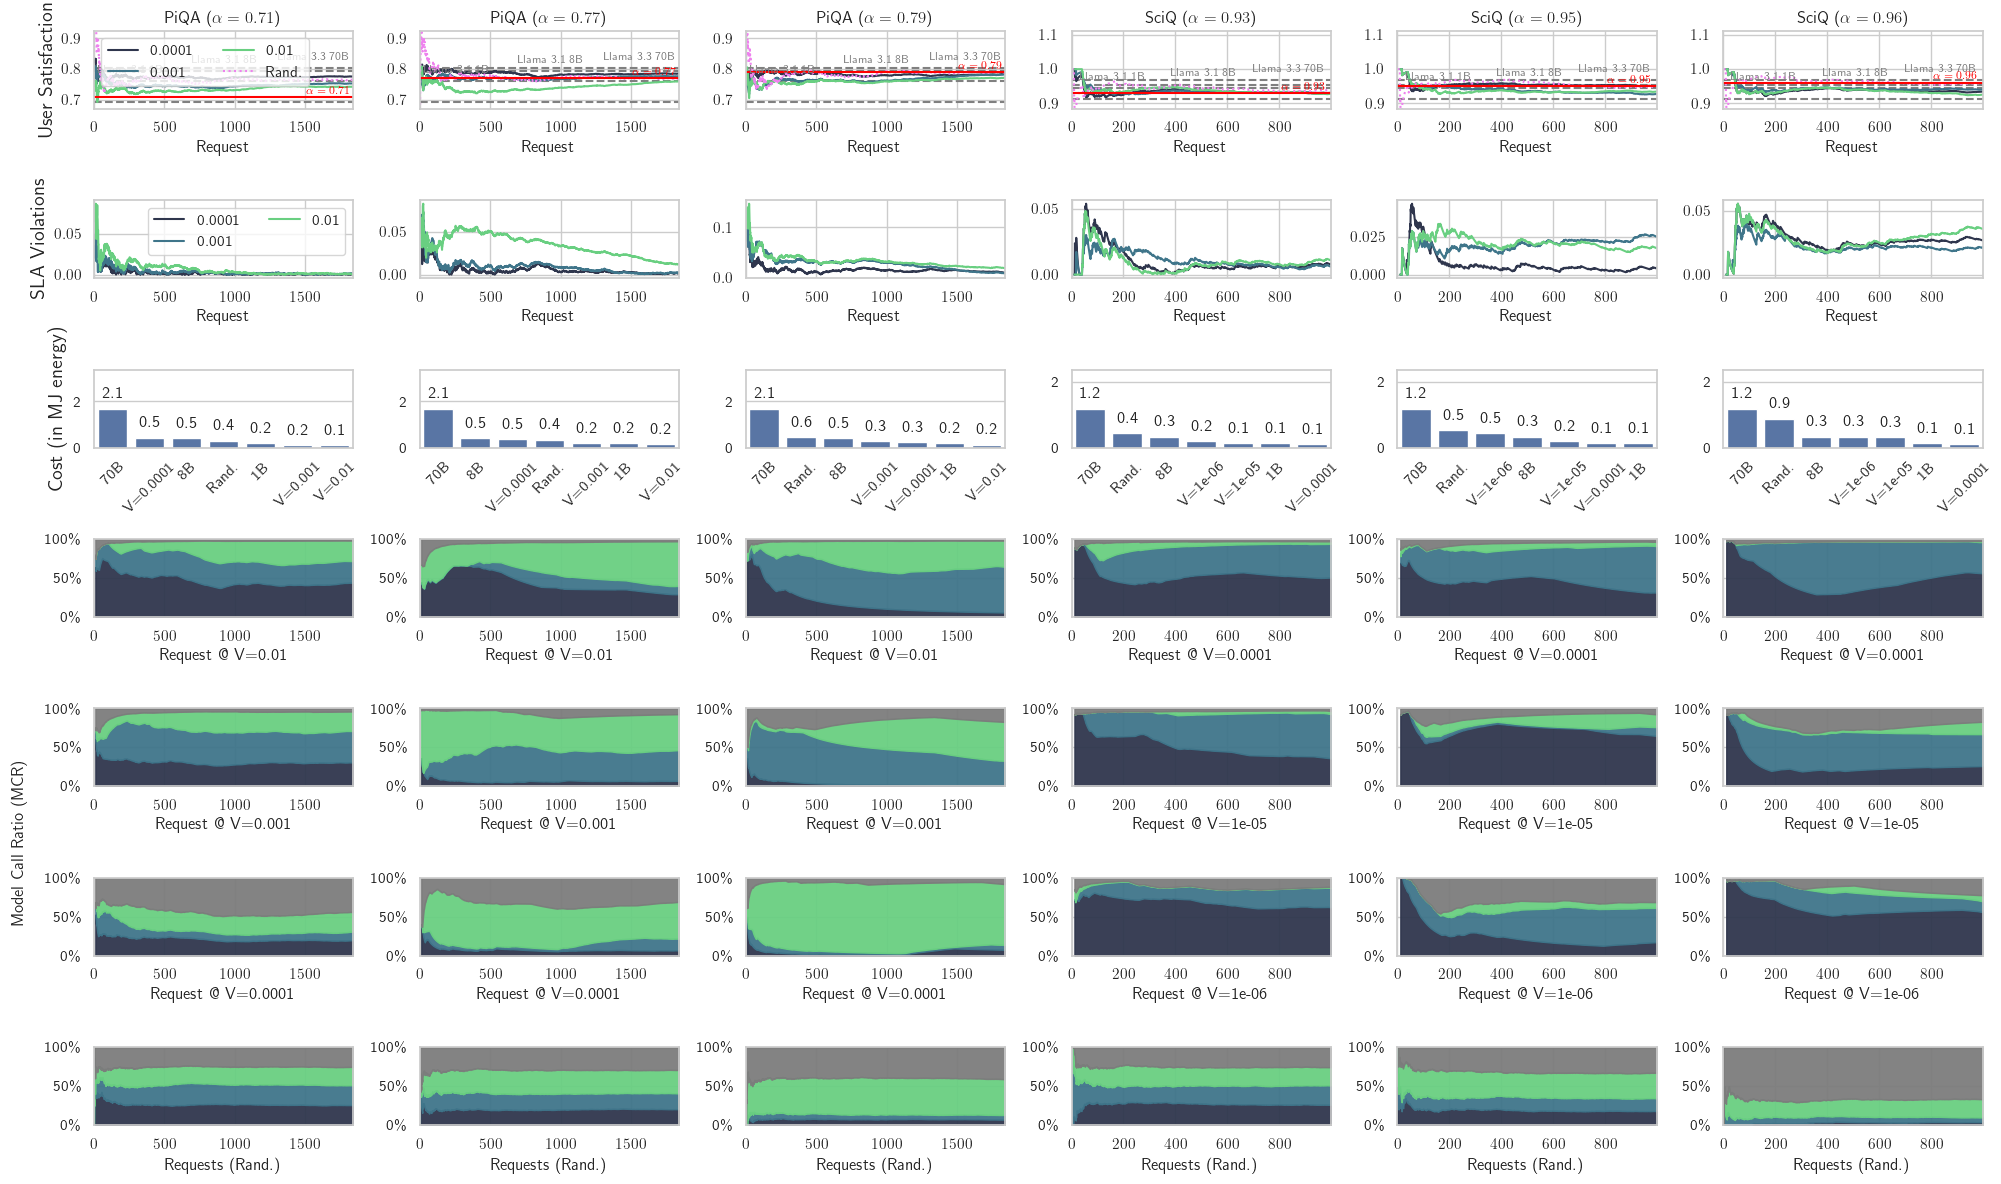

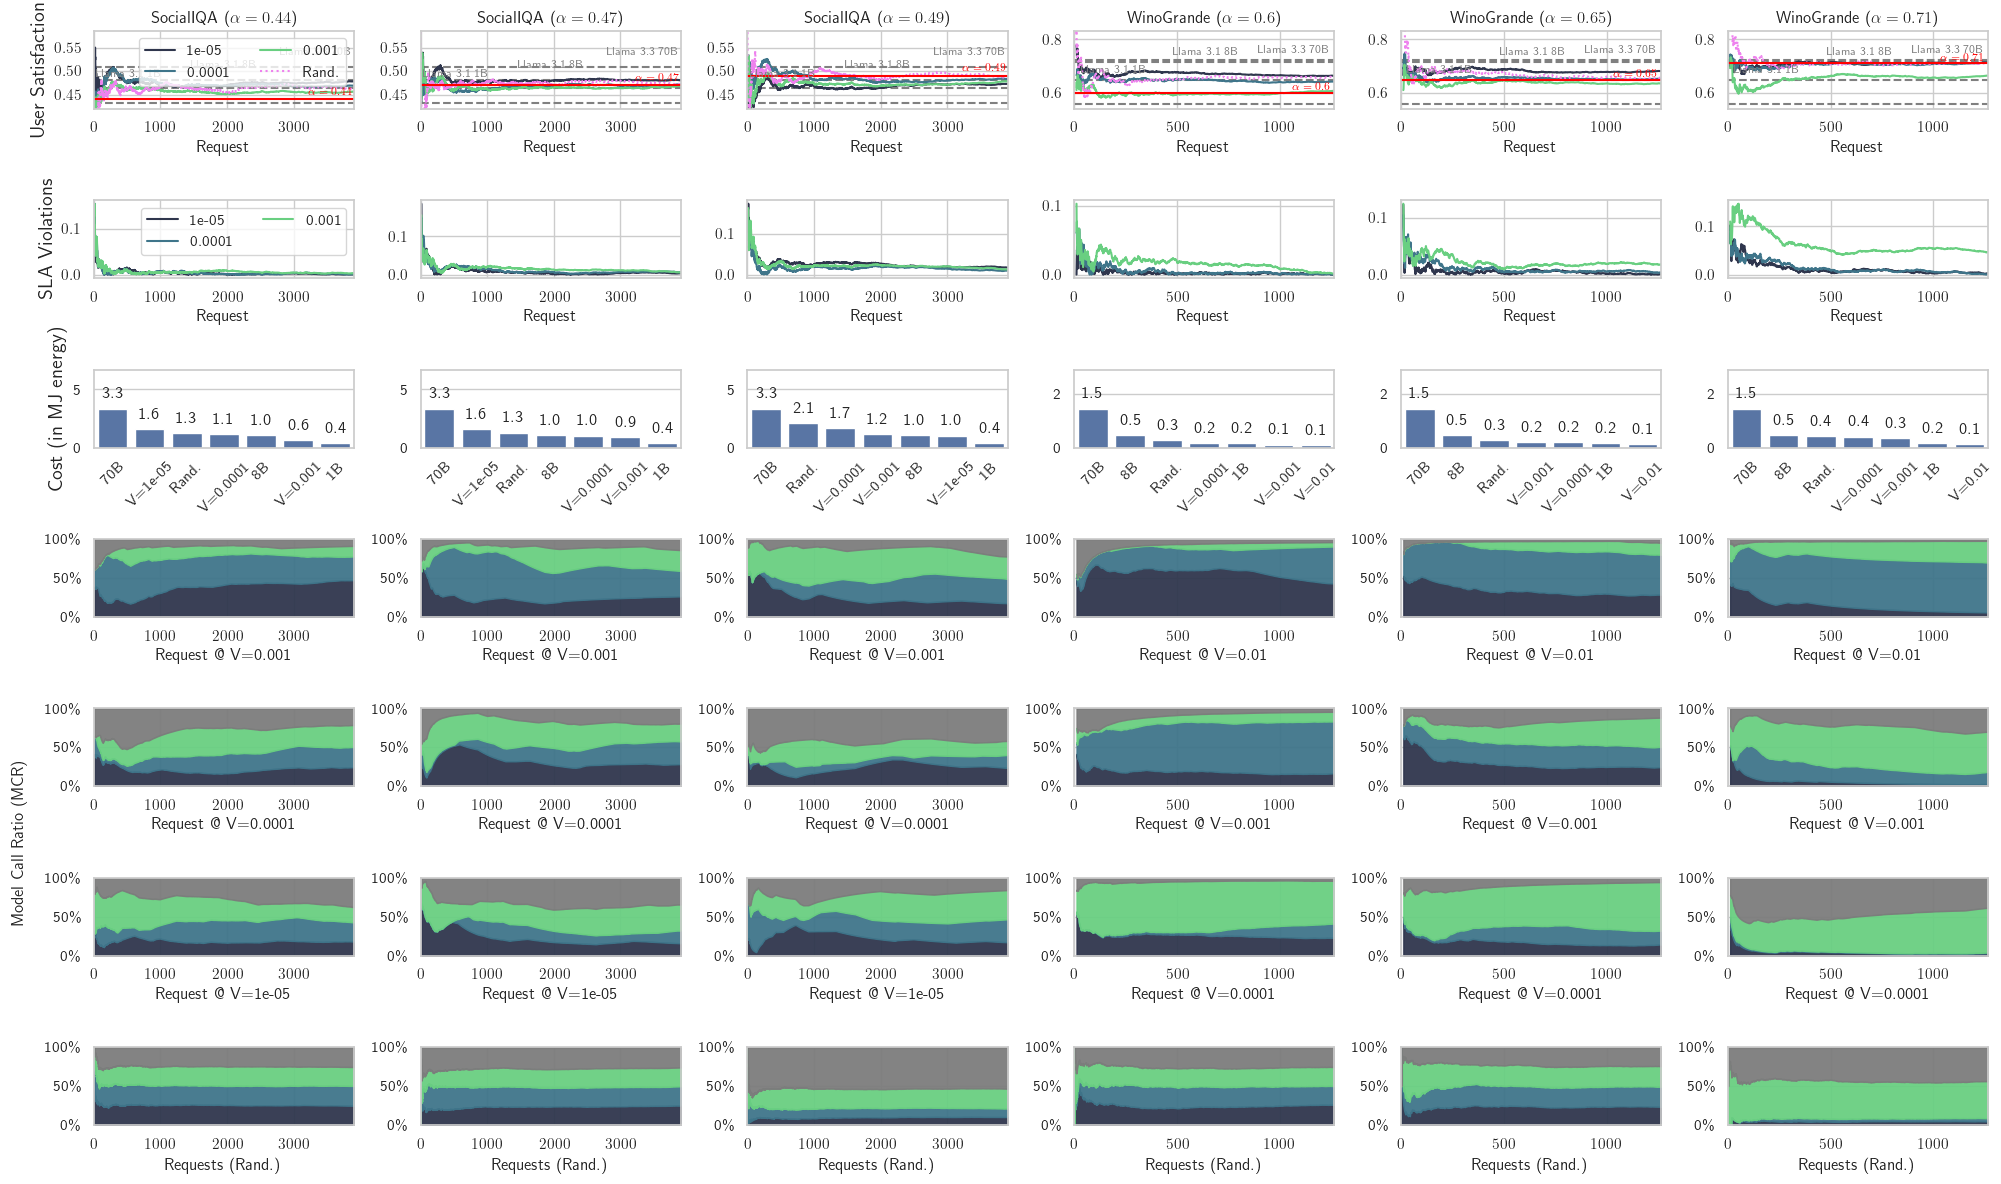

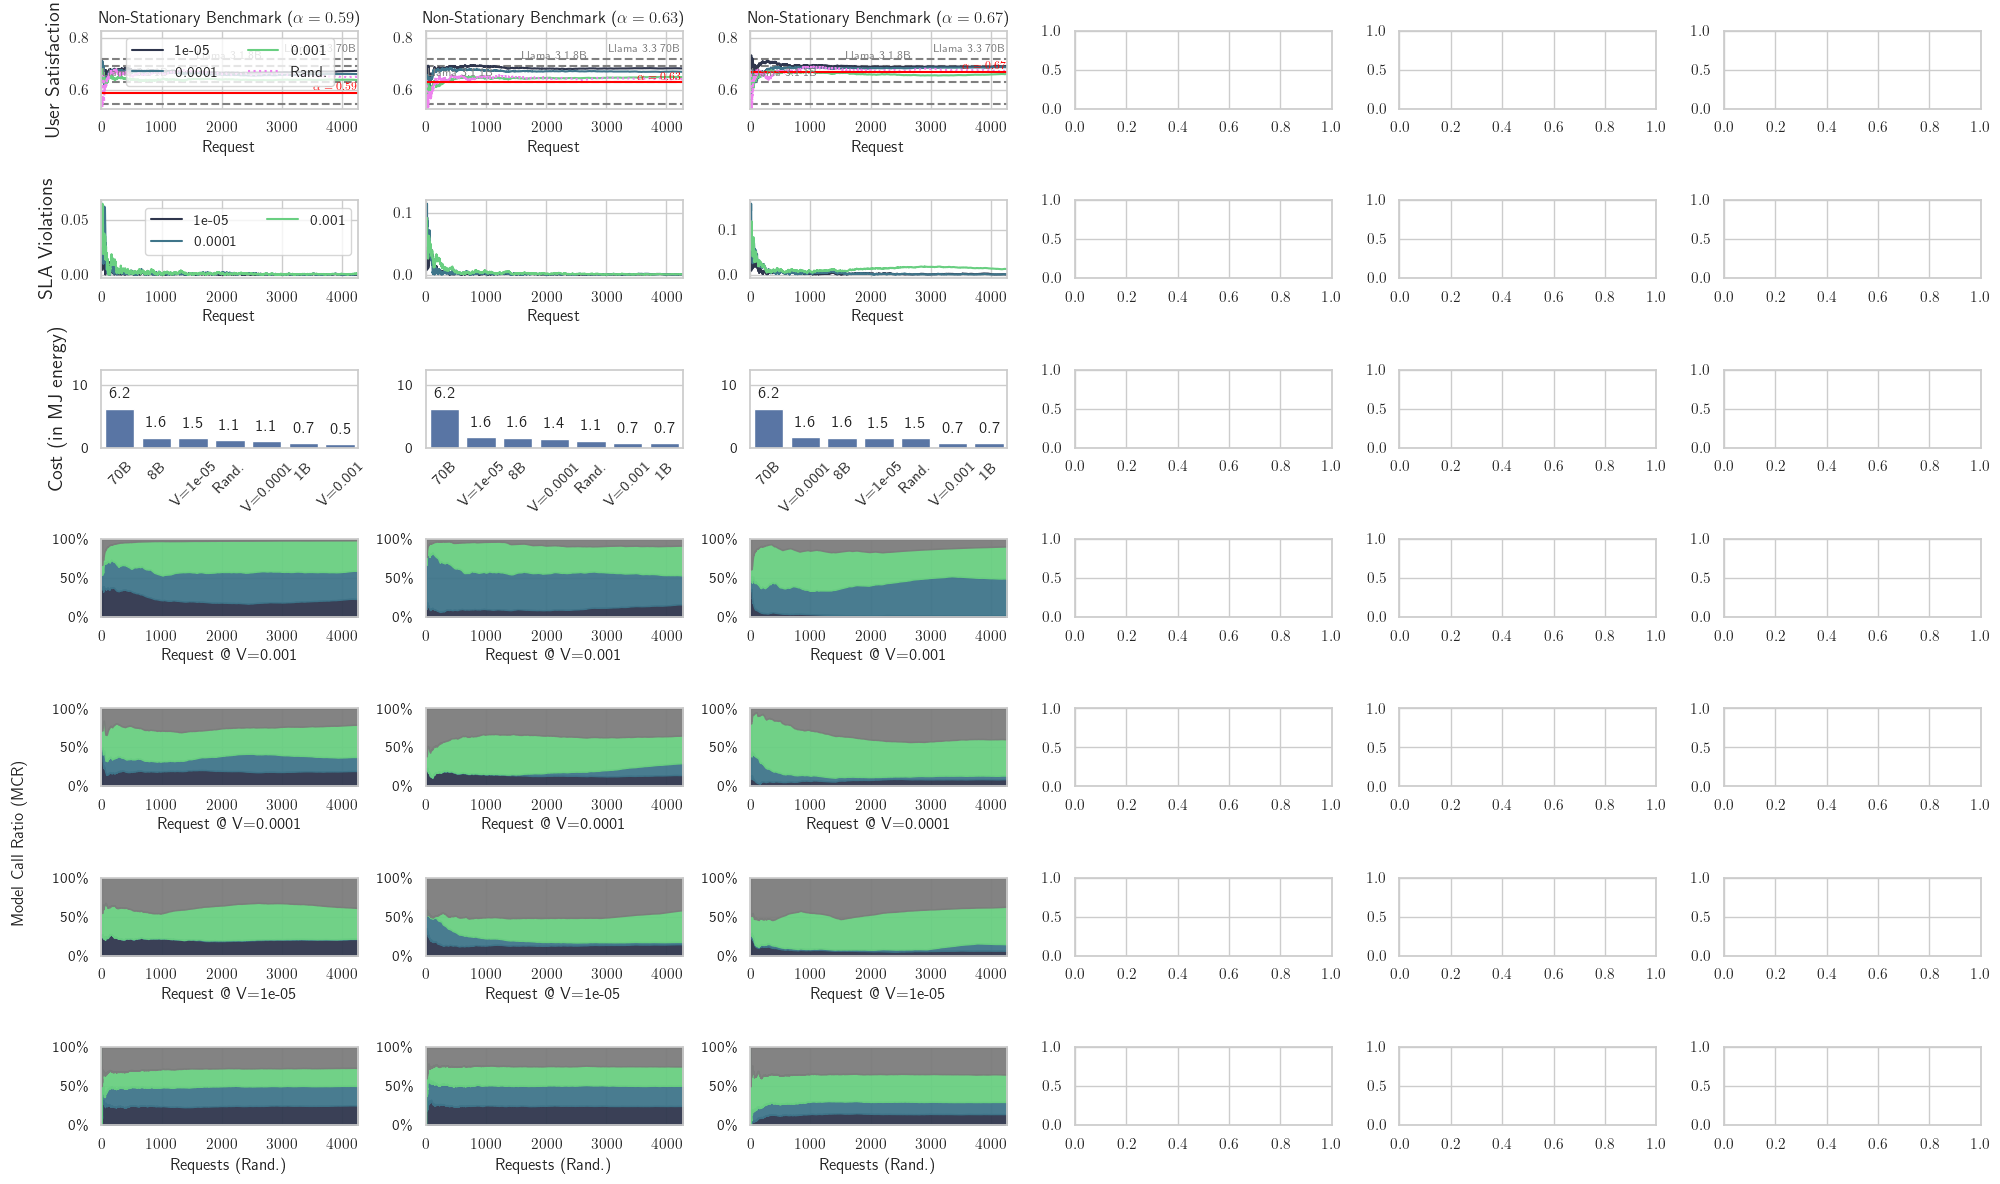

In [145]:
# Plot generator

BENCHMARK_NAME_DICT = {
    "arc_challenge": "ARC Challenge",
    "arc_easy": "ARC Easy",
    "boolq": "BoolQ",
    # "lambada_standard": "Lambada",
    "logiqa": "LogiQA",
    # "logiqa2": "LogiQA2",
    "piqa": "PiQA",
    "sciq": "SciQ",
    "social_iqa": "SocialIQA",
    "winogrande": "WinoGrande",
	"non_iid_chained": "Non-Stationary Benchmark"
}

# Create a list of all benchmark-alpha combinations
benchmark_alpha_combinations = []
for name in v_values_per_benchmark.keys():
    config_path = Path(f"{NOTEBOOK_PATH.parent}/config/{MODEL_FAMILY}/online/{name}.yaml")
    with config_path.open("r") as f:
        import yaml
        CONFIG = yaml.safe_load(f)

    algorithm_config = CONFIG["algorithm"]
    for alpha in algorithm_config["alpha_values"]:
        benchmark_alpha_combinations.append((name, alpha))

# Initialize plotting variables
plot_num = 0
col_count = 0

# Iterate through all benchmark-alpha combinations
for combo_idx, (name, alpha) in enumerate(benchmark_alpha_combinations):

    # Create new figure every 6 columns
    if col_count == 0:
        sns.set(style="whitegrid")
        fig, axes = plt.subplots(nrows=7, ncols=6, figsize=(20, 12))
        plot_num += 1

    # Get current column index
    col_idx = col_count

    # Skip if this benchmark doesn't have V values configured
    if name not in v_values_per_benchmark.keys():
        continue

    # Filter data for current benchmark and alpha
    subset = run_df.loc[(run_df["benchmark_name"] == name) &
                       (run_df["c"] == 0.1) &
                       (run_df["V"].isin(v_values_per_benchmark[name])) &
                       (run_df["_step"] > 10) &
                       (run_df["alpha"] == alpha)]

    v_values = subset["V"].unique().tolist()

    # Accuracy Plot
    raw_inference_accuracies_per_model = infer_df[["benchmark_name"] + [f"label_{model}" for model in MODEL_LABEL_NAMES]].groupby("benchmark_name").mean().loc[name]

    axes[0][col_idx].text(s="Llama 3.1 1B", x=subset["_step"].min() + 20, y=raw_inference_accuracies_per_model["label_small"] + 0.025, color='gray', fontsize=8, ha="left")
    axes[0][col_idx].text(s="Llama 3.1 8B", x=(subset["_step"].min() + 1/2 * subset["_step"].max()), y=raw_inference_accuracies_per_model["label_medium"] + 0.025, color='gray', fontsize=8, ha="center")
    axes[0][col_idx].text(s="Llama 3.3 70B", x=subset["_step"].max() - 20, y=raw_inference_accuracies_per_model["label_large"] + 0.025, color='gray', fontsize=8, ha="right")

    for model in MODEL_LABEL_NAMES:
	    axes[0][col_idx].axhline(y=raw_inference_accuracies_per_model[f"label_{model}"], color='gray', linestyle='--')

    sns.lineplot(
        data=subset.loc[(subset["alpha"] == alpha)],
        x="_step",
        y="avg_accuracy",
        hue="V",
        errorbar=None,
        ax=axes[0][col_idx],
        legend=True if col_idx == 0 else False,
	    palette=["#2f364d", "#3f758a", "#69cf81", "#7c7c7c"][:len(MODEL_LABEL_NAMES)],
    )

    axes[0][col_idx].plot(
		baseline_df.loc[(baseline_df["benchmark_name"] == name) & (baseline_df["alpha"] == alpha), "_step"],
		baseline_df.loc[(baseline_df["benchmark_name"] == name) & (baseline_df["alpha"] == alpha),"avg_accuracy"],
		color="violet", linestyle="dotted", label="Rand."
	)

    axes[0][col_idx].axhline(y=alpha, color='red', linestyle='-')
    axes[0][col_idx].text(s=r"$ \alpha = {alpha_val} $ ".format(alpha_val=alpha), x=subset["_step"].max() - 20, y=alpha + 0.01, color='red', fontsize=8, ha="right")

    axes[0][col_idx].set(ylim=[0.97 * raw_inference_accuracies_per_model[f"label_{MODEL_LABEL_NAMES[0]}"], 1.15 * raw_inference_accuracies_per_model[f"label_{MODEL_LABEL_NAMES[-1]}"]])

    if col_idx == 0:
        axes[0][col_idx].legend(ncols=2)

    # Q Plot for SLA violations
    subset.loc[(subset["alpha"] == alpha), "sla_violations"] = subset.loc[(subset["alpha"] == alpha), "mess_plus/q_length"] / subset.loc[(subset["alpha"] == alpha), "_step"]
    sns.lineplot(
        data=subset.loc[(subset["alpha"] == alpha)],
        x="_step",
        y="sla_violations",
        hue="V",
        errorbar=None,
        ax=axes[1][col_idx],
        legend=True if col_idx == 0 else False,
	    palette=["#2f364d", "#3f758a", "#69cf81"]
    )

    if col_idx == 0:
        axes[1][col_idx].legend(ncols=2)

    # Energy consumption plot
    random_baseline_energy = baseline_df.loc[baseline_df["alpha"] == alpha, ["benchmark_name", "mess_plus/energy"]].groupby("benchmark_name").sum().loc[name].to_frame()
    random_baseline_energy["V"] = "Rand."
    random_baseline_energy["mess_plus/energy"] = random_baseline_energy[name]
    random_baseline_energy.reset_index(inplace=True)

    raw_inference_energy_data = infer_df[["benchmark_name", "energy_consumption_large", "energy_consumption_medium", "energy_consumption_small"]].groupby("benchmark_name").sum().loc[name].to_frame()
    raw_inference_energy_data["V"] = raw_inference_energy_data.index
    raw_inference_energy_data["mess_plus/energy"] = raw_inference_energy_data[name]
    raw_inference_energy_data.rename({name: "mess_plus/energy"}, inplace=True)
    raw_inference_energy_data.reset_index(inplace=True)

    raw_inference_energy_data["V"] = raw_inference_energy_data["V"].replace({"energy_consumption_large": "70B", "energy_consumption_medium": "8B", "energy_consumption_small": "1B"}, inplace=False)

    raw_inference_energy_data.drop([name, "index"], inplace=True, axis=1)
    energy_data = subset.loc[(subset["alpha"] == alpha)].groupby(["_step", "V"]).agg({"mess_plus/energy": "mean"}).groupby("V")["mess_plus/energy"].sum().reset_index()

    energy_data["V"] = energy_data["V"].apply(lambda sample: f"V={sample}")

    energy_data = pd.concat([random_baseline_energy, raw_inference_energy_data, energy_data], ignore_index=True)
    energy_data.reset_index(inplace=True)
    energy_data = energy_data.sort_values(by=["mess_plus/energy"], ascending=False)

    sns.barplot(
        data=energy_data,
        x="V",
        y="mess_plus/energy",
        ax=axes[2][col_idx],
        errorbar=("ci", 0.95),
    )

    add_value_labels(axes[2][col_idx])
    axes[2][col_idx].yaxis.set_major_formatter(plt.FuncFormatter(fmt_to_megajoules))
    axes[2][col_idx].set(ylim=[0, 2 * energy_data["mess_plus/energy"].max()])
    axes[2][col_idx].tick_params(axis='x', labelrotation=45)

    # Stackplot for Model Call Ratio
    for jdx, V in enumerate(v_values_per_benchmark[name]):

        stack_df = subset.loc[
            (run_df["benchmark_name"] == name) &
            (run_df["V"] == V) &
            (subset["alpha"] == alpha),
            ["_step"] + [f"models/{model}_chosen" for model in MODEL_LABEL_NAMES]
        ].groupby(["_step"]).mean().reset_index()

        x = stack_df["_step"]
        y = stack_df[[f"models/{model}_chosen" for model in MODEL_LABEL_NAMES]]
        y_stack = np.cumsum(y, axis=1)

        axes[3 + jdx][col_idx].fill_between(x, 0, y_stack.iloc[:, 0], color="#2f364d", alpha=0.95)
        axes[3 + jdx][col_idx].fill_between(x, y_stack.iloc[:, 0], y_stack.iloc[:, 1], color="#3f758a", alpha=0.95)
        axes[3 + jdx][col_idx].fill_between(x, y_stack.iloc[:, 1], y_stack.iloc[:, 2], color="#69cf81", alpha=0.95)
        axes[3 + jdx][col_idx].fill_between(x, y_stack.iloc[:, 2], y_stack.iloc[:, 3], color="#7c7c7c", alpha=0.95)
        axes[3 + jdx][col_idx].set(xlabel=f"Request @ V={V}", xlim=[0, subset.loc[(subset["alpha"] == alpha), "_step"].max()], ylim=[0, 1])
        axes[3 + jdx][col_idx].yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

        # if jdx == 0 and col_idx == 0:
        #     axes[3 + jdx][col_idx].legend(["Llama 3.1 1B", "Llama 3.1 8B", "Llama 3.3 70B"])

    # Add area plot for random baseline with constraint.
    baseline_stack_df = baseline_df.loc[
            (baseline_df["benchmark_name"] == name) &
            (baseline_df["alpha"] == alpha),
            ["_step"] + [f"models/{model}_chosen" for model in MODEL_LABEL_NAMES]
        ].groupby(["_step"]).mean().reset_index()

    x_base = baseline_stack_df["_step"]
    y_base = baseline_stack_df[[f"models/{model}_chosen" for model in MODEL_LABEL_NAMES]]
    y_stack_base = np.cumsum(y_base, axis=1)

    axes[6][col_idx].fill_between(x_base, 0, y_stack_base.iloc[:, 0], color="#2f364d", alpha=0.95)
    axes[6][col_idx].fill_between(x_base, y_stack_base.iloc[:, 0], y_stack_base.iloc[:, 1], color="#3f758a", alpha=0.95)
    axes[6][col_idx].fill_between(x_base, y_stack_base.iloc[:, 1], y_stack_base.iloc[:, 2], color="#69cf81", alpha=0.95)
    axes[6][col_idx].fill_between(x_base, y_stack_base.iloc[:, 2], y_stack_base.iloc[:, 3], color="#7c7c7c", alpha=0.95)
    axes[6][col_idx].set(xlabel=f"Requests (Rand.)", xlim=[0, baseline_stack_df["_step"].max()], ylim=[0, 1])
    axes[6][col_idx].yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    axes[6][col_idx].set(xlim=[0, baseline_stack_df["_step"].max()])

    # Set axis properties
    axes[0][col_idx].set(xlabel="Request", xlim=[0, subset.loc[(subset["alpha"] == alpha), "_step"].max()])
    axes[1][col_idx].set(xlabel="Request", xlim=[0, subset.loc[(subset["alpha"] == alpha), "_step"].max()])
    axes[2][col_idx].set(xlabel="")

    # Remove y-labels for columns after the first
    if col_idx > 0:
        axes[0][col_idx].set(ylabel=None)
        axes[1][col_idx].set(ylabel=None)
        axes[2][col_idx].set(ylabel=None)

    # Set title for each column
    axes[0][col_idx].set_title(r"{bm_name} ($\alpha = {alpha_val} $)".format(bm_name=BENCHMARK_NAME_DICT[name], alpha_val=alpha))

    # Increment column counter
    col_count += 1

    # Check if we need to save the current figure and start a new one
    if col_count == 6 or combo_idx == len(benchmark_alpha_combinations) - 1:
        # Add row labels
        for idx, (ax, row) in enumerate(zip(axes[:,0], ["User Satisfaction", "SLA Violations", "Cost (in MJ energy)", "", "", "", ""])):
            if idx == 5:
                fig.text(0.003, 0.225, "Model Call Ratio (MCR)", ha="center", rotation='vertical', fontsize=plt.rcParams['axes.labelsize'])
            else:
                ax.set_ylabel(row, rotation=90, size='large')

        # Save the figure
        fig.tight_layout()
        write_figure_to_disk(plt, file_name=f"benchmark_performance_plot_{plot_num}", chapter_name="evaluations")

        # Reset column counter for next figure
        col_count = 0

In [146]:
def build_pivot_table_for_main_results(input_df: pd.DataFrame, model_cols: list):
	latest_steps = input_df.groupby(['benchmark_name', 'alpha'])['_step'].transform('max')
	is_last_step = input_df['_step'] == latest_steps

	for col in model_cols:
		input_df = input_df.rename(columns={col: f"final_{col}"})

	# Create new columns with the final values
	# for col in model_cols:
	#     final_values = input_df.loc[is_last_step, ['benchmark_name', 'alpha', col]]
	#     final_values = final_values.drop_duplicates(['benchmark_name', 'alpha'])
	#     input_df = pd.merge(
	#         input_df,
	# 	    final_values.rename(columns={col: f"final_{col}"}),
	#         on=['benchmark_name', 'alpha'],
	#         how='left'
	#     )
	#
	# display(input_df.columns)

	# Add the final model values to the pivot table
	merged_pvt_table = input_df.loc[:, ["benchmark_name", "alpha", "V", "avg_accuracy", "mess_plus/energy"] + [f"final_{col}" for col in model_cols]].pivot_table(
	    index=["benchmark_name", "alpha"],
	    columns=["V"],
	    values=["avg_accuracy", "mess_plus/energy"] + [f"final_{col}" for col in model_cols],
	    aggfunc={
	        "avg_accuracy": ["mean", "std"],
	        "mess_plus/energy": ["sum", "std"],
	        **{f"final_{col}": ['mean'] for col in model_cols}
	    }
	)

	return merged_pvt_table



In [158]:
# Create pivot tables for our random baseline, RouteLLM, and MESS+

# SINGLE MODEL
pvt_base_model = infer_df[["benchmark_name", "energy_consumption_large", "energy_consumption_medium", "energy_consumption_small", "energy_consumption_xsmall", "label_xsmall", "label_small", "label_medium", "label_large"]].pivot_table(
    index=["benchmark_name"],
    values=["energy_consumption_large", "energy_consumption_medium", "energy_consumption_small", "energy_consumption_xsmall", "label_xsmall", "label_small", "label_medium", "label_large"],
    aggfunc={
        "energy_consumption_large": ["sum", "std"],
        "energy_consumption_medium": ["sum", "std"],
        "energy_consumption_small": ["sum", "std"],
        "energy_consumption_xsmall": ["sum", "std"],
        "label_xsmall": ["mean", "std"],
        "label_small": ["mean", "std"],
        "label_medium": ["mean", "std"],
        "label_large": ["mean", "std"],
    }
)

pvt_base_model.columns = pd.MultiIndex.from_tuples(
    map(lambda x: (x[0], x[1], 2), pvt_base_model.columns)
)

new_cols = []
for col in pvt_base_model.columns:
	if col[0] == "energy_consumption_xsmall":
		new_cols.append(("mess_plus/energy", col[1], 2))
	elif col[0] == "energy_consumption_small":
		new_cols.append(("mess_plus/energy", col[1], 3))
	elif col[0] == "energy_consumption_medium":
		new_cols.append(("mess_plus/energy", col[1], 4))
	elif col[0] == "energy_consumption_large":
		new_cols.append(("mess_plus/energy", col[1], 5))
	elif col[0] == "label_xsmall":
		new_cols.append(("avg_accuracy", col[1], 2))
	elif col[0] == "label_small":
		new_cols.append(("avg_accuracy", col[1], 3))
	elif col[0] == "label_medium":
		new_cols.append(("avg_accuracy", col[1], 4))
	elif col[0] == "label_large":
		new_cols.append(("avg_accuracy", col[1], 5))

pvt_base_model.columns = pd.MultiIndex.from_tuples(new_cols, names=[None, None, "V"])

# Add the new "final_models/{size}_chosen" columns with values of 1.0
for size in MODEL_LABEL_NAMES:
	num_size = 2
	if size == 'xsmall':
		num_size = 2
	elif size == 'small':
		num_size = 3
	elif size == 'medium':
		num_size = 4
	elif size == "large":
		num_size = 5

	pvt_base_model[(f'final_models/{size}_chosen'), "first", num_size] = 1.0

# Sort the columns for better organization (by size group)
pvt_base_model = pvt_base_model.sort_index(axis=1, level=0)

# RouteLLM
# filtered_routellm_df = pd.DataFrame()
# for benchmark_name, val_dict in ROUTELLM_THRESHOLD_ALPHA_MAP.items():
# 	for alpha, threshold in val_dict.items():
# 		filtered_routellm_df = pd.concat([
# 			filtered_routellm_df,
# 			routellm_bs_df.loc[(routellm_bs_df["alpha"] == alpha) & (routellm_bs_df["threshold"] == threshold) & (routellm_bs_df["benchmark_name"] == benchmark_name)]
# 		], ignore_index=True)

# Convert to Megajoule
# filtered_routellm_df["mess_plus/energy"] = filtered_routellm_df["mess_plus/energy"] / 1_000_000
# filtered_routellm_df["V"] = 1000 # Dummy to identify RouteLLM in the final latex output.
# pvt_routellm = build_pivot_table_for_main_results(filtered_routellm_df, ["models/small_chosen", "models/large_chosen"])

# RouterDC baseline
# routerdc_bs_df["V"] = 10000
# pvt_routerdc_baseline = build_pivot_table_for_main_results(routerdc_bs_df, ["models/small_chosen", "models/medium_chosen", "models/large_chosen"])

baseline_df["V"] = 100
pvt_rand_baseline = build_pivot_table_for_main_results(baseline_df, [f"models/{model}_chosen" for model in MODEL_LABEL_NAMES])

# This is an intermediary step to average across seeds.
pvt_mess_plus = build_pivot_table_for_main_results(run_df, [f"models/{name}_chosen" for name in MODEL_LABEL_NAMES])

combined_pivot = None
combined_pivot = pd.concat([pvt_mess_plus, pvt_rand_baseline], axis=1) # pvt_routerdc_baseline, pvt_routellm

display(combined_pivot.loc[(combined_pivot.index.get_level_values(0) == "non_iid_chained") & (combined_pivot.index.get_level_values(1) == 0.67), (combined_pivot.columns.get_level_values(2) == 0.0001)])
display(pvt_rand_baseline)

# Select alpha values per benchmark
# TODO: @Ryan, make sure to adjust the values in the 'replace_level_0()' function as well, if you change it.
bm_alpha = {
	"arc_challenge": 0.55,
	"arc_easy": 0.77,
	"boolq": 0.80,
	"logiqa": 0.33,
	"piqa": 0.79,
	"sciq": 0.93,
	"social_iqa": 0.47,
	"winogrande": 0.71,
	"non_iid_chained": 0.67
}

display(f"Mean alpha across benchmarks: {np.mean([i for i in bm_alpha.values()])}")

selected_pivot = pd.DataFrame()
for k, v in bm_alpha.items():
	selected_pivot = pd.concat([
		selected_pivot,
		combined_pivot.loc[(combined_pivot.index.get_level_values(0) == k) & (combined_pivot.index.get_level_values(1) == v)]
	])


# if combined_pivot is not None:
# 	selected_pivot = combined_pivot.iloc[1::3]
# else:
# 	selected_pivot = pvt_mess_plus

selected_pivot = selected_pivot.query('benchmark_name != "lambada_standard" & benchmark_name != "logiqa2"')

print("All experiments combined")
# display(selected_pivot.index)
def replace_level_0(idx_tuple):
	# Replace only 'A' with 'X', leave others unchanged
	benchmark_name_mapping = {
		"arc_challenge": r"ARC Challenge ($\alpha = 55\%$)",
		"arc_easy": r"ARC Easy ($\alpha = 77\%$)",
		"boolq": r"BoolQ  ($\alpha = 80\%$)",
		"logiqa": r"LogiQA ($\alpha = 33\%$)",
		"piqa": r"PiQA ($\alpha = 79\%$)",
		"sciq": r"SciQ ($\alpha = 93\%$)",
		"social_iqa": r"SocialIQA ($\alpha = 47\%$)",
		"winogrande": r"Winogrande ($\alpha = 71\%$)",
		"non_iid_chained": r"Non-stationary Benchmark ($\alpha = 67\%$)"
	}

	if type(idx_tuple) == tuple:
		return (benchmark_name_mapping[idx_tuple[0]], idx_tuple[1])
	else:
		return benchmark_name_mapping[idx_tuple]

# Apply the replacement function
new_index = selected_pivot.index.map(replace_level_0)
selected_pivot.index = pd.MultiIndex.from_tuples(new_index, names=selected_pivot.index.names)
# display(selected_pivot.columns.get_level_values(2))
selected_pivot = selected_pivot.droplevel('alpha', axis=0)
selected_pivot = selected_pivot.loc[:, (selected_pivot.columns.get_level_values(2) == 0.000001) | (selected_pivot.columns.get_level_values(2) == 100) | (selected_pivot.columns.get_level_values(2) == 1000) | (selected_pivot.columns.get_level_values(2) == 10000)]

# Merge pivot from single model experiments
pvt_base_model.index = pvt_base_model.index.map(replace_level_0)

if combined_pivot is not None:
	selected_pivot = pd.concat([selected_pivot, pvt_base_model], axis=1)
else:
	selected_pivot = pvt_mess_plus

benchmark_names = selected_pivot.index

# Step 2: Create a new MultiIndex from the stacked data
stacked_data = []
for v_value in selected_pivot.columns.get_level_values('V').unique():
	for b_name in benchmark_names:
		for metric in selected_pivot.columns.get_level_values(0).unique():
			for agg_type in selected_pivot.columns.get_level_values(1).unique():
				if (metric, agg_type, v_value) in selected_pivot.columns:
					value = selected_pivot.loc[b_name, (metric, agg_type, v_value)]
					stacked_data.append((v_value, b_name, metric, agg_type, value))


# Step 3: Create a new DataFrame from the stacked data
selected_pivot = pd.DataFrame(stacked_data, columns=['V', 'benchmark_name', 'metric', 'aggregation_type', 'value'])

# Step 4: Pivot to get the desired format
selected_pivot = selected_pivot.pivot(
	index='V',
	columns=['benchmark_name', 'metric', 'aggregation_type'],
	values='value'
)

# Re-order the rows
idx_new = []
for row in selected_pivot.index:
	if row < 1:
		idx_new.append(100000)
	else:
		idx_new.append(row)

selected_pivot.index = idx_new
selected_pivot.sort_index(inplace=True)

selected_pivot.index = ["Qwen2 0.5B", "Qwen2 1.5B", "Qwen2 7B", "Qwen2.5 32B", "Random w. Constraint", r"\textbf{MESS+ (ours)}"]
selected_pivot = selected_pivot.fillna(0)

def multiply_if_small(x):
	if isinstance(x, (int, float)) and x <= 1 and x != 0:  # Exclude zero if needed
		return x * 100
	return x

# Apply the function to all elements in the DataFrame
selected_pivot = selected_pivot.applymap(multiply_if_small)

selected_pivot.loc[:, (selected_pivot.columns.get_level_values(1) == "mess_plus/energy") & (selected_pivot.columns.get_level_values(2) == "sum")] /= 1_000_000
selected_pivot.loc[:, (selected_pivot.columns.get_level_values(1) == "mess_plus/energy") & (selected_pivot.columns.get_level_values(2) == "std")] /= 1_000_000
selected_pivot.loc[selected_pivot.index == r"\textbf{MESS+ (ours)}", (selected_pivot.columns.get_level_values(1) == "mess_plus/energy") & (selected_pivot.columns.get_level_values(2) == "sum")] /= 9

# We add a new "AVERAGE L1 ITEM
level2_level3_means = selected_pivot.groupby(level=[1, 2], axis=1).mean()
new_column_tuples = [("Mean",) + col for col in level2_level3_means.columns]
new_columns = pd.MultiIndex.from_tuples(new_column_tuples)

# Create a DataFrame with the new columns
means_df = pd.DataFrame(level2_level3_means.values, index=selected_pivot.index, columns=new_columns)

# Concatenate the original DataFrame with the means DataFrame
selected_pivot = pd.concat([selected_pivot, means_df], axis=1)

selected_pivot.loc[(selected_pivot.index == "Qwen 2 0.5B") | (selected_pivot.index == "Qwen2 1.5B") | (selected_pivot.index == "Qwen2 7B") | (selected_pivot.index == "Qwen2.5 32B"), (selected_pivot.columns.get_level_values(1) == "avg_accuracy") & (selected_pivot.columns.get_level_values(2) == "std")] /= 9 # We ran raw inference calls on 3 seeds and then ran our experiments on 3 seeds again, i.e., 3x3 = 9

selected_pivot.loc[(selected_pivot.index == "Qwen2 0.5B"), (selected_pivot.columns.get_level_values(1) == "final_models/xsmall_chosen") & (selected_pivot.columns.get_level_values(2) == "mean")] = 100.0
selected_pivot.loc[(selected_pivot.index == "Qwen2 1.5B"), (selected_pivot.columns.get_level_values(1) == "final_models/small_chosen") & (selected_pivot.columns.get_level_values(2) == "mean")] = 100.0
selected_pivot.loc[(selected_pivot.index == "Qwen2 7B"), (selected_pivot.columns.get_level_values(1) == "final_models/medium_chosen") & (selected_pivot.columns.get_level_values(2) == "mean")] = 100.0
selected_pivot.loc[(selected_pivot.index == "Qwen2.5 32B"), (selected_pivot.columns.get_level_values(1) == "final_models/large_chosen") & (selected_pivot.columns.get_level_values(2) == "mean")] = 100.0




# display(selected_pivot)

avg_accuracy           final_models/large_chosen  \
                              mean       std                      mean   
V                           0.0001    0.0001                    0.0001   
benchmark_name  alpha                                                    
non_iid_chained 0.67      0.685732  0.022882                  0.432472   

                      final_models/medium_chosen final_models/small_chosen  \
                                            mean                      mean   
V                                         0.0001                    0.0001   
benchmark_name  alpha                                                        
non_iid_chained 0.67                    0.414321                  0.085093   

                      final_models/xsmall_chosen mess_plus/energy  \
                                            mean              std   
V                                         0.0001           0.0001   
benchmark_name  alpha                                               
non_iid_chained 0.67                    0.068114       324.683294   

                                     
                                sum  
V                            0.0001  
benchmark_name  alpha                
non_iid_chained 0.67   1.397240e+07

avg_accuracy           final_models/large_chosen  \
                              mean       std                      mean   
V                              100       100                       100   
benchmark_name  alpha                                                    
arc_challenge   0.35      0.458874  0.029352                  0.255372   
                0.45      0.464729  0.032340                  0.255970   
                0.55      0.537648  0.036595                  0.722432   
arc_easy        0.60      0.691617  0.019411                  0.220747   
                0.70      0.715784  0.014201                  0.271247   
                0.77      0.774585  0.012747                  0.764943   
boolq           0.70      0.779503  0.015828                  0.247033   
                0.80      0.798713  0.011478                  0.305786   
                0.87      0.875755  0.009883                  0.743521   
logiqa          0.28      0.288867  0.033788                  0.226183   
                0.33      0.300834  0.037035                  0.428829   
                0.38      0.383812  0.039069                  0.806660   
non_iid_chained 0.59      0.659044  0.024884                  0.278721   
                0.63      0.642687  0.023900                  0.243275   
                0.67      0.674381  0.021550                  0.347056   
piqa            0.71      0.766732  0.026069                  0.252349   
                0.77      0.775630  0.027201                  0.295790   
                0.79      0.785175  0.021584                  0.400383   
sciq            0.93      0.943529  0.011487                  0.249668   
                0.95      0.956000  0.011992                  0.313786   
                0.96      0.962869  0.012189                  0.670877   
social_iqa      0.44      0.460947  0.027963                  0.245373   
                0.47      0.473099  0.018282                  0.276426   
                0.49      0.490565  0.015530                  0.532054   
winogrande      0.60      0.657487  0.033016                  0.254207   
                0.65      0.672187  0.037771                  0.229842   
                0.71      0.715863  0.036680                  0.431946   

                      final_models/medium_chosen final_models/small_chosen  \
                                            mean                      mean   
V                                            100                       100   
benchmark_name  alpha                                                        
arc_challenge   0.35                    0.233717                  0.257758   
                0.45                    0.248616                  0.257469   
                0.55                    0.206345                  0.031385   
arc_easy        0.60                    0.271230                  0.262307   
                0.70                    0.272149                  0.242387   
                0.77                    0.203535                  0.015924   
boolq           0.70                    0.254165                  0.243865   
                0.80                    0.290605                  0.205576   
                0.87                    0.182700                  0.038905   
logiqa          0.28                    0.287173                  0.264200   
                0.33                    0.220613                  0.184497   
                0.38                    0.087990                  0.053983   
non_iid_chained 0.59                    0.228936                  0.247222   
                0.63                    0.247750                  0.259649   
                0.67                    0.361115                  0.154246   
piqa            0.71                    0.228586                  0.250112   
                0.77                    0.295460                  0.207807   
                0.79                    0.461672                  0.062657   
sciq       

'Mean alpha across benchmarks: 0.668888888888889'

All experiments combined


/var/folders/yz/mgc_jz0x28j0kgl9dm72cwp40000gn/T/ipykernel_62660/1245696508.py:200: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  selected_pivot = selected_pivot.applymap(multiply_if_small)
/var/folders/yz/mgc_jz0x28j0kgl9dm72cwp40000gn/T/ipykernel_62660/1245696508.py:207: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  level2_level3_means = selected_pivot.groupby(level=[1, 2], axis=1).mean()


In [150]:
import math
import re

# CREATE LATEX TABLE
def multiindex_df_to_latex_chunked(
		df,
		chunk_size=3,
		level2_order=None,
		caption_template="Results Table Part {}",
		label_template="tab:results_part{}", include_index=True
):
	# Get unique level 1 items
	level1_items = df.columns.get_level_values(0).unique()

	# Get level 2 items (either in specified order or existing order)
	if level2_order is None:
		level2_items = df.columns.get_level_values(1).unique()
	else:
		# Verify all specified level2 items exist in the DataFrame
		existing_level2 = df.columns.get_level_values(1).unique()
		for item in level2_order:
			if item not in existing_level2:
				raise ValueError(f"Level 2 item '{item}' not found in DataFrame")
		level2_items = level2_order

	# Calculate number of chunks
	num_chunks = math.ceil(len(level1_items) / chunk_size)

	latex_tables = []

	# Process each chunk
	for chunk_idx in range(num_chunks):
		start_idx = chunk_idx * chunk_size
		end_idx = min((chunk_idx + 1) * chunk_size, len(level1_items))

		# Get level 1 items for this chunk
		chunk_level1_items = level1_items[start_idx:end_idx]

		# Filter DataFrame to only include these level 1 items
		chunk_columns = [col for col in df.columns if col[0] in chunk_level1_items]
		chunk_df = df[chunk_columns]

		# Create a new DataFrame for the LaTeX output with the same higher-level structure
		# Get unique combinations of first two levels in this chunk
		higher_levels = chunk_df.columns.droplevel(2).unique()

		# Create new DataFrame with appropriate multi-index
		result_df = pd.DataFrame(index=df.index)
		result_cols = []

		# For each combination of higher levels, combine mean and std
		all_alph = []
		for level1 in chunk_level1_items:
			pattern = r"\\alpha\s*=\s*(\d+)\\%"
			match = re.search(pattern, level1)
			if match:
			    number = match.group(1)  # This will be "50" as a string
			    number_int = int(number)  # Convert to integer if needed
			else:
			    print("No number found")
			    number_int = 0

			alph = number_int
			all_alph.append(alph)

			for level2 in level2_items:
				if "final_models/large" in level2:
					name = r"\thead{Model Call Ratio \\ (Q32B/Q7B/Q1.5B/Q0.5B)}"
					result_df[(level1, name)] = [f"{w:.0f}\\% / {x:.0f}\\% / {y:.0f}\\% / {z:.0f}\\%" for w, x, y, z in zip(df[(level1, "final_models/large_chosen", "mean")], df[(level1, "final_models/medium_chosen", "mean")], df[(level1, "final_models/small_chosen", "mean")], df[(level1, "final_models/xsmall_chosen", "mean")])]
					result_cols.append((level1, name))
					continue

				try:
					if level2 == "avg_accuracy":
						name = r"\thead{Request. \\ Satisfaction}"
						level3 = "mean"

						mean_val = df[level1, level2, level3]
						std_val = df[level1, level2, 'std']

						if level1 == "Mean":
							alph = 66.625

						vals = []
						for m, s in zip(mean_val, std_val):
							if m >= alph:
								vals.append(f"\\textcolor{{darkgreen}}{{{m:.2f}$\\scriptscriptstyle\\pm{s:.2f}$}}")
							else:
								vals.append(f"\\textcolor{{red}}{{{m:.2f}$\\scriptscriptstyle\\pm{s:.2f}$}}")

					elif level2 == "mess_plus/energy":
						name = r"\thead{Operating \\ Cost}"
						level3 = "sum"
						mean_val = df[level1, level2, level3]
						std_val = df[level1, level2, 'std']
						min_mean_val = mean_val[3:].min()

						mean_acc = df[level1, "avg_accuracy", "mean"]
						if level1 == "Mean":
							alph = 66.625

						vals = []
						acc_match = mean_acc[:4] >= alph
						is_min_single_satisfying = np.where(acc_match == True)[0]
						for idx, (m, s) in enumerate(zip(mean_val, std_val)):
							if m == mean_val[4:].min():
								vals.append(f"\\textbf{{{m:.2f}$\\scriptscriptstyle\\pm{s:.2f}$}}")
							elif len(is_min_single_satisfying) > 0 and idx == is_min_single_satisfying[0]:
								vals.append(f"\\underline{{{m:.2f}$\\scriptscriptstyle\\pm{s:.2f}$}}")
							else:
								vals.append(f"{m:.2f}$\\scriptscriptstyle\\pm{s:.2f}$")

					else:
						name = level2
						level3 = "mean"
						mean_val = df[level1, level2, level3]
						std_val = df[level1, level2, 'std']
						vals = [f"{m:.2f}$\\scriptscriptstyle\\pm{s:.2f}$" for m, s in zip(mean_val, std_val)]

					result_df[(level1, name)] = vals
					result_cols.append((level1, name))

				except KeyError:
					# Skip if mean or std not available
					print(f"Warning: Missing mean or std for {level1}, {level2}")

		# Set the columns with multi-index (preserving top 2 levels)
		result_df.columns = pd.MultiIndex.from_tuples(result_cols, names=['Category', 'Subcategory'])

		# Convert to LaTeX with multi-index
		caption = caption_template.format(chunk_idx + 1)
		label = label_template.format(chunk_idx + 1)

		latex_str = result_df.to_latex(escape=False, multicolumn=True, multicolumn_format='c', index=include_index)

		# Add caption and label
		latex_str = latex_str.replace('\\begin{tabular}',
		                              f'\\begin{{table}}\n\\caption{{{caption}}}\n\\label{{{label}}}\n\\begin{{tabular}}')
		latex_str = latex_str + '\\end{table}'
		latex_str = latex_str.replace("\\toprule", "\\cmidrule(lr){1-1}\cmidrule(lr){2-4}\cmidrule(lr){5-7}\cmidrule(lr){8-10}")
		latex_str = latex_str.replace("\\midrule", "\\cmidrule(lr){1-1}\cmidrule(lr){2-4}\cmidrule(lr){5-7}\cmidrule(lr){8-10}")
		latex_str = latex_str.replace("\\bottomrule", "\\cmidrule(lr){1-1}\cmidrule(lr){2-4}\cmidrule(lr){5-7}\cmidrule(lr){8-10}")

		latex_tables.append(latex_str)

	return latex_tables


latex_tables = multiindex_df_to_latex_chunked(
	selected_pivot,
	chunk_size=3,
	caption_template="Results Table Part {}: Categories",
	label_template="tab:results_part{}",
	level2_order=["mess_plus/energy", "avg_accuracy", "final_models/large_chosen"]
)

for t in latex_tables:
	print(t)

No number found
\begin{table}
\caption{Results Table Part 1: Categories}
\label{tab:results_part1}
\begin{tabular}{llllllllll}
\cmidrule(lr){1-1}\cmidrule(lr){2-4}\cmidrule(lr){5-7}\cmidrule(lr){8-10}
Category & \multicolumn{3}{c}{ARC Challenge ($\alpha = 55\%$)} & \multicolumn{3}{c}{ARC Easy ($\alpha = 77\%$)} & \multicolumn{3}{c}{BoolQ  ($\alpha = 80\%$)} \\
Subcategory & \thead{Operating \\ Cost} & \thead{Request. \\ Satisfaction} & \thead{Model Call Ratio \\ (Q32B/Q7B/Q1.5B/Q0.5B)} & \thead{Operating \\ Cost} & \thead{Request. \\ Satisfaction} & \thead{Model Call Ratio \\ (Q32B/Q7B/Q1.5B/Q0.5B)} & \thead{Operating \\ Cost} & \thead{Request. \\ Satisfaction} & \thead{Model Call Ratio \\ (Q32B/Q7B/Q1.5B/Q0.5B)} \\
\cmidrule(lr){1-1}\cmidrule(lr){2-4}\cmidrule(lr){5-7}\cmidrule(lr){8-10}
Qwen2 0.5B & 0.20$\scriptscriptstyle\pm0.00$ & \textcolor{red}{30.03$\scriptscriptstyle\pm45.85$} & 0\% / 0\% / 0\% / 100\% & 0.21$\scriptscriptstyle\pm0.00$ & \textcolor{red}{54.88$\scriptscriptstyle